# Bike Sharing Demand Prediction


## Overview

Kaggle competition: https://www.kaggle.com/c/bike-sharing-demand

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

## Feature Description
The data set (https://www.kaggle.com/c/bike-sharing-demand/data) consists of two spreadsheets - 1. train.csv, containing data to train the prediction algorithm and 2. test.csv, containing data to test the prediction algorithm. The data fields in the train.csv are enumerated below  
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
- holiday - whether the day is considered a holiday  
- workingday - whether the day is neither a weekend nor holiday  
- weather -
     - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
     - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
     - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
     - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
- temp - temperature in Celsius  
- atemp - "feels like" temperature in Celsius  
- humidity - relative humidity  
- windspeed - wind speed  
- casual - number of non-registered user rentals initiated  
- registered - number of registered user rentals initiated  
- count - number of total rentals  


## Problem Statement 

The goal of this project is to combine the historical bike usage patterns with the weather data in order to forecast bike rental demand. 

+ Target Column to be predicted: 'count'
+ Input Columns used as variables (8 columns): ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
    * The other two columns (casual and registered) comprises of the split-up of the target column 'count'. 
    
## Motivation

Several bike/scooter ride sharing facilities (e.g., Bird, Capital Bikeshare, Citi Bike) have started up lately especially in metropolitan cities like San Francisco, New York, Chicago and Los Angeles, and one of the most important problem from a business point of view is to predict the bike demand on any particular day. While having excess bikes results in wastage of resource (both with respect to bike maintenance and the land/bike stand required for parking and security), having fewer bikes leads to revenue loss (ranging from a short term loss due to missing out on immediate customers to potential longer term loss due to loss in future customer base), Thus, having a estimate on the demands would enable efficient functioning of these companies. 

In [909]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

## Data Set Overview

### Load the data

In [910]:
# Read the data
mydata = pd.read_csv('./Data/train.csv', parse_dates=True, index_col='datetime')
testdata = pd.read_csv('./Data/test.csv', parse_dates=True, index_col='datetime')

### Shape of the data

In [911]:
print('Shape of data: ', mydata.shape)

Shape of data:  (10886, 11)


The provided data consists of over 10k observations with 11 column variables (excluding the datetime column - which has been used as an index)

### Look into the first few observations

In [912]:
mydata.head(3)

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40  
2011-01-01 02:00:00        80        0.0       5          27     32

### Column Data Types

In [913]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


Data consists of 12 columns variables and all of them are Numeric Columns. 

### Statistical Details for every column
Below table provides the statistical details for each column. 

In [914]:
mydata.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [915]:
print(mydata.index[[0, -1]]) # Range of time stamp

DatetimeIndex(['2011-01-01 00:00:00', '2012-12-19 23:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [916]:
print('Casual + Registered = Count? ', ~(mydata.casual + mydata.registered - mydata['count']).any())

Casual + Registered = Count?  True


### Summary

The below table summarizes the column content for the data

| Column Name | Format | Range | Explanation |
|-|-|-|-|
| datetime | yyyy-mm-dd hh:mm:ss | 2011-01-01 00:00:00 to<br>2012-12-19 23:00:00 | hourly date + time stamp|
| season | int64 | 1 to 4 | 1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter |
| holiday | int64 | 0 or 1 | 1 = Holiday, 0 = Not a Holiday |
| workingday | int64 | 0 or 1 | 1 = Neither a weekend nor holiday, 0 = Either a weekend or a holiday |
| weather | int64 | 1 to 4 | 1 = Clear, Few clouds, Partly cloudy, Partly cloudy <br> 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br> 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  <br> 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp | float64 | -0.82 to 41 | Temperature in Celsius | 
| atemp | float64 | 0.76 to 45.46 | 'Feels like" temperature in Celsius |
| humidity | int64 | 0 to 100 | Relative humidity | 
| windspeed | float64 | 0 to 57 | Wind Speed | 
| casual | int64 | 0 to 367 | Number of non-registered user rentals initiated | 
| registered | int64 | 0 to 886 | Number of registered user rentals initiated |
| count | int64 | 1 to 977 | Number of total rentals (casual + registered) |

### Initial Predictions

+ The target column (count) which refers to the number of bikes that have been rented at that hour, ranges between 1 and 977 over the 2 year span. 
+ Mean(count) = 192, with median and 75% quantile = 145 and 284, respectively. This suggests that the 'count' distribution is more denser at lower values. This is expected as out of 24 hours, we would expect the bike demand/usage to be high for maximum of maybe 6 hours or so. 
+ Would expect the strongest correlation from hours component in the datetime column
+ During weekdays most of the bikers would probably be the local commuters (more likely registered users) and during weekends and holidays, the majority of the bikers are more likely to be tourists (casual riders) 



## Look into our Feature Set

### Categorical Data

From the above set of 8 variables, we notice that the 4 of those columns ['season', 'holiday', 'workingday', 'weather'] should be category data types.  Converting these 4 features to categories

In [917]:
# Converting into categorical data
category_list = ['season', 'holiday', 'workingday', 'weather']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

In [918]:
# Mapping numbers to understandable text
season_dict = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
weather_dict = {1:'Clear', 2:'Misty+Cloudy', 3:'Light Snow/Rain', 4:'Heavy Snow/Rain'}
mydata['season'] = mydata['season'].map(season_dict)
mydata['weather'] = mydata['weather'].map(weather_dict)

testdata['season'] = testdata['season'].map(season_dict)
testdata['weather'] = testdata['weather'].map(weather_dict)

mydata.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2011-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2011-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2011-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40  
2011-01-01 02:00:00        80        0.0       5          27     32

### Count Distribution w.r.t. Weather, Season, Working Day 
Let us see how 'count' = number of bikes rented varies across the various categorical data (weather, season, working day)

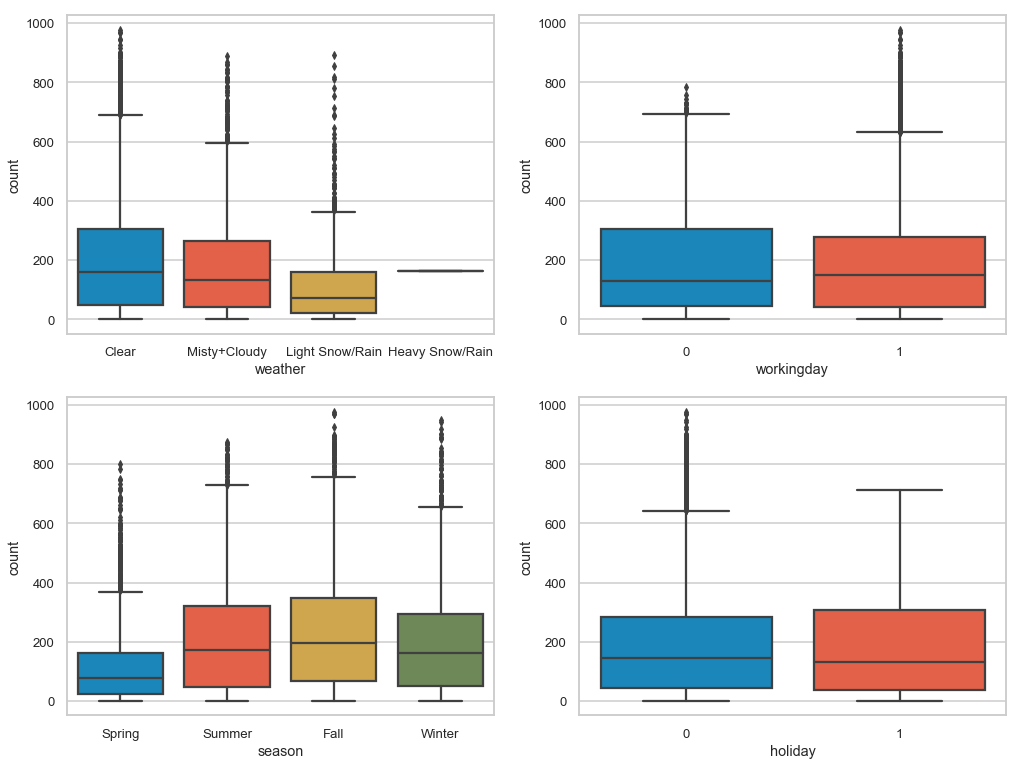

In [919]:
# Seaborn boxplots to get an idea of the distribution/outliers
f, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.boxplot(data=mydata, y='count', x='weather', ax=axes[0][0])
sns.boxplot(data=mydata, y='count', x='workingday', ax=axes[0][1])
sns.boxplot(data=mydata, y='count', x='season', ax=axes[1][0])
sns.boxplot(data=mydata, y='count', x='holiday', ax=axes[1][1])

plt.show()

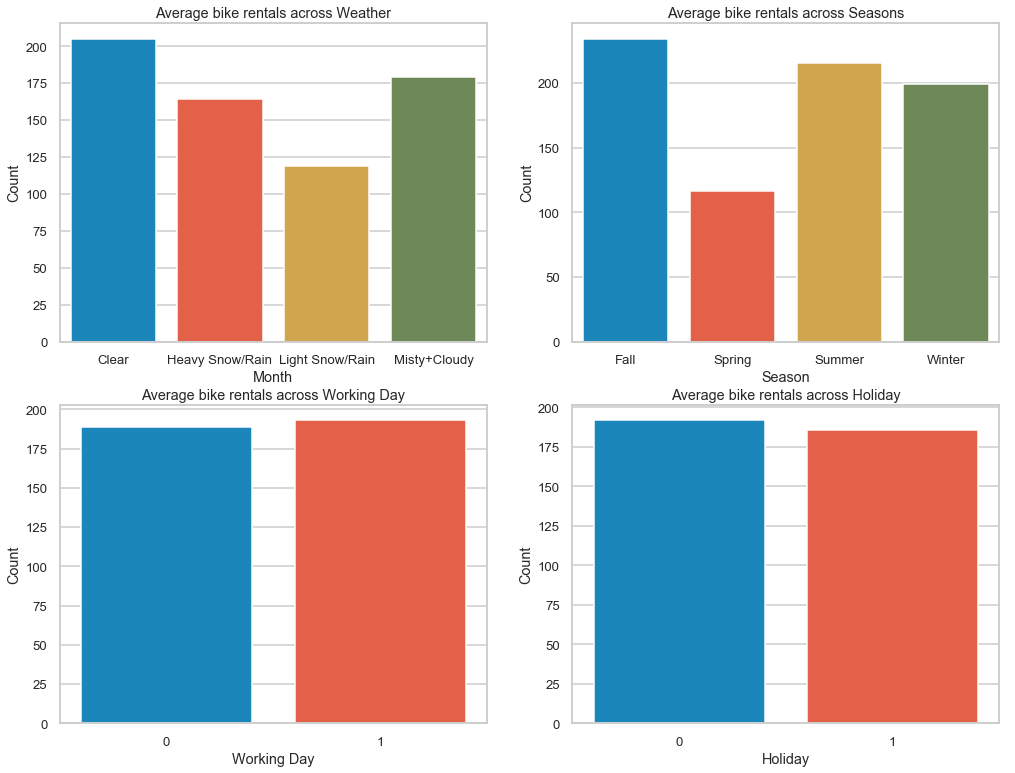

In [920]:
# Average values across each of the categorical columns 
fig = plt.figure(figsize=(15, 12))
axes = fig.add_subplot(2, 2, 1)
group_weather = pd.DataFrame(mydata.groupby(['weather'])['count'].mean()).reset_index()
sns.barplot(data=group_weather, x='weather', y='count', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals across Weather')

axes = fig.add_subplot(2, 2, 2)
group_season = pd.DataFrame(mydata.groupby(['season'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='season', y='count', ax=axes)
axes.set(xlabel='Season', ylabel='Count', title='Average bike rentals across Seasons')

axes = fig.add_subplot(2, 2, 3)
group_workingday = pd.DataFrame(mydata.groupby(['workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_workingday, x='workingday', y='count', ax=axes)
axes.set(xlabel='Working Day', ylabel='Count', title='Average bike rentals across Working Day')

axes = fig.add_subplot(2, 2, 4)
group_season = pd.DataFrame(mydata.groupby(['holiday'])['count'].mean()).reset_index()
sns.barplot(data=group_season, x='holiday', y='count', ax=axes)
axes.set(xlabel='Holiday', ylabel='Count', title='Average bike rentals across Holiday')
plt.show()

#### Few Observations
+ Higher biker rentals as weather is more clear and sunny. 
+ Just '1 hour' instance where there were rentals under heavy rain/snow condition. Two possibilities
    + Could be an outlier
    + Reservations made at a time when the weather was good. But weather conditions logged sometime later in the same hour when the conditions were heavy rains/snow
+ Bike reservations are lesser in Spring season copared to Summer and Fall
+ Lots of outlier points for a particular seasons or weather conditions. This is most likely due to variable distribution across the day

### Count Distribution w.r.t Temperature 
Now let us see how number of bikes rented depends on the temperature

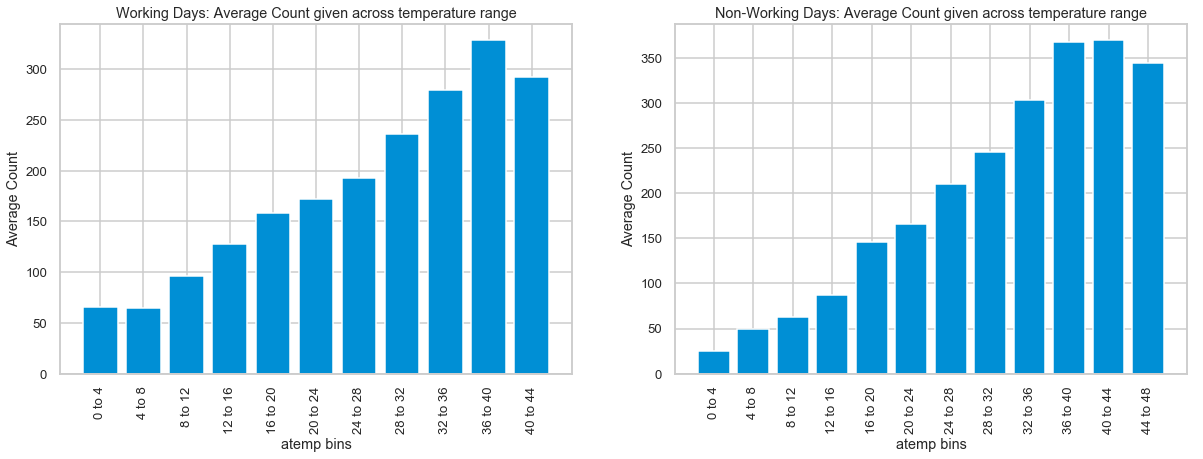

In [921]:
# Splitting data into working-day and non-working day
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

bin_size = 4
mydata_w['temp_round'] = mydata_w['atemp']//bin_size
mydata_nw['temp_round'] = mydata_nw['atemp']//bin_size

mean_count_vs_temp_w = mydata_w.groupby('temp_round')['count'].mean()
mean_count_vs_temp_nw = mydata_nw.groupby('temp_round')['count'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('atemp bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average Count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('atemp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average Count given across temperature range')

plt.show()

**Observation**
* From thea bove histogram plot, we can see that there is a steady increase in the average bikes rented with temperature with a small decrease at the highest temperature bin

## Data Wrangling, Cleaning & Feature Engineering

### Missing Data Fields

From the above .info() command, we notice that every column has 10886 (= number of rows) non-null values. This seems to be a very clean set of data and there are no missing data in any of the 'row x columns'.  



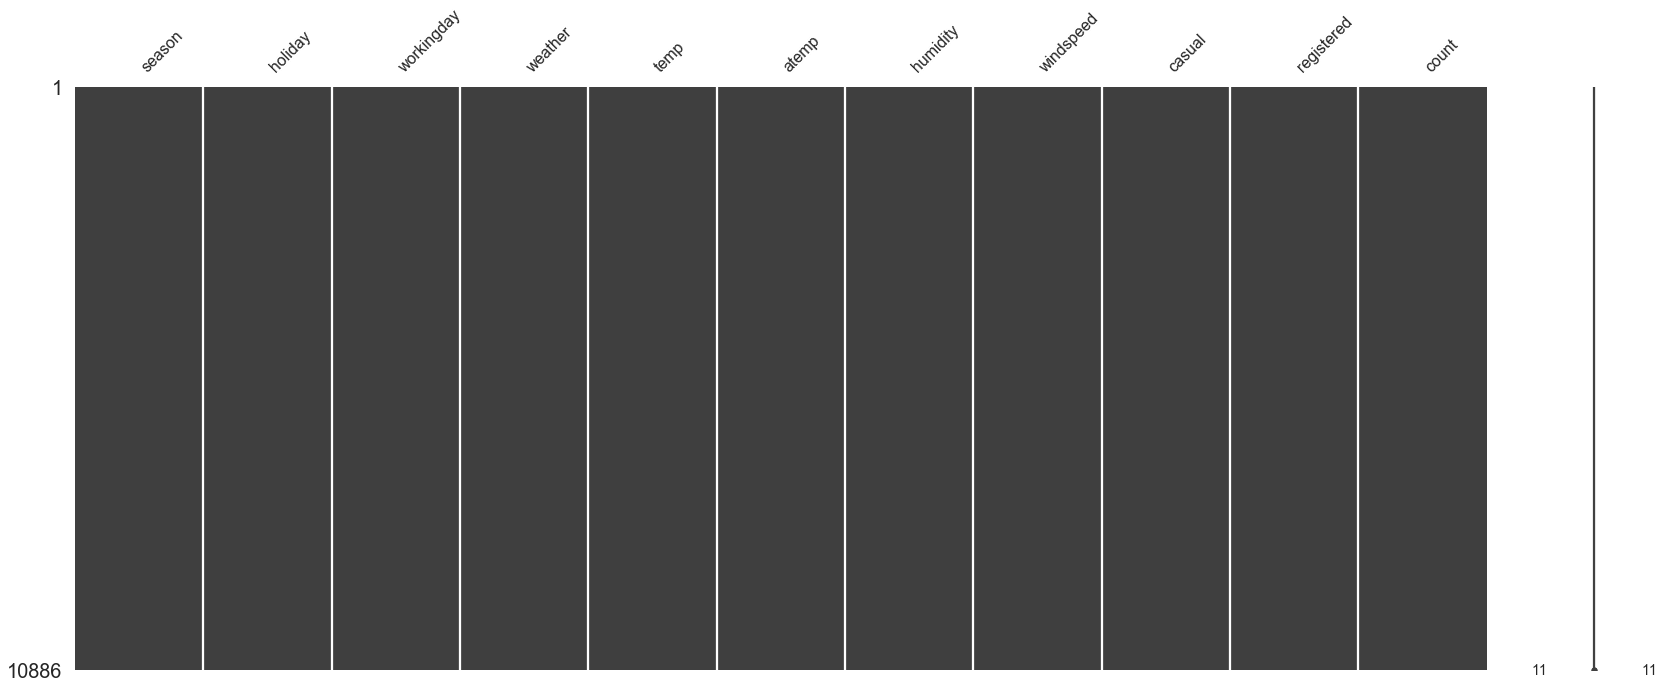

In [922]:
msno.matrix(mydata)

### Feature Engineering - Part 1

Lets, split the datetime column into ['month', 'date', 'day', 'hour'] categories since the bike demand is more likely dependent on these individual categories. Creating these 4 additional category columns 

In [923]:
# Splitting datetime object into month, date, hour and day category columns
mydata['month'] = [x.month for x in mydata.index]
mydata['date'] = [x.day for x in mydata.index]
mydata['hour'] = [x.hour for x in mydata.index]
mydata['day'] = [x.weekday() for x in mydata.index]

testdata['month'] = [x.month for x in testdata.index]
testdata['date'] = [x.day for x in testdata.index]
testdata['hour'] = [x.hour for x in testdata.index]
testdata['day'] = [x.weekday() for x in testdata.index]

category_list = ['month', 'date', 'hour', 'day']
for var in category_list:
    mydata[var] = mydata[var].astype('category')
    testdata[var] = testdata[var].astype('category')

In [924]:
# Mapping 0 to 6 day to Monday to Saturday
day_dict = {0:'Monday', 1:'Teusday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
mydata['day'] = mydata['day'].map(day_dict)
testdata['day'] = testdata['day'].map(day_dict)

mydata.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2011-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2011-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2011-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16     1   
2011-01-01 01:00:00        80        0.0       8          32     40     1   
2011-01-01 02:00:00        80        0.0       5          27     32     1   

                    date hour       day  
datetime                                 
2011-01-01 00:00:00    1    0  Saturday  
2011-01-01 01:00:00    1    1  Saturday  
2011-01-01 02:00:00    1    2  Saturday

#### Hourly Distribution

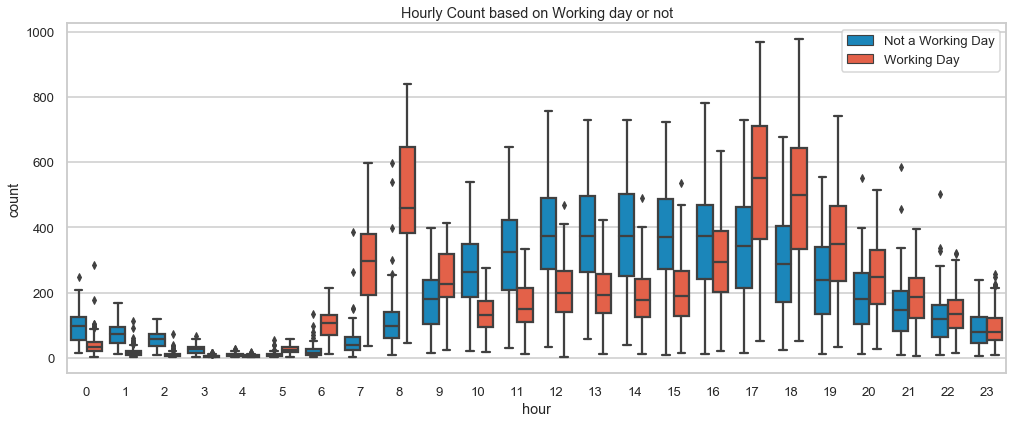

In [925]:
# seaborn boxplots across hours
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=mydata, y='count', x='hour', hue='workingday', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

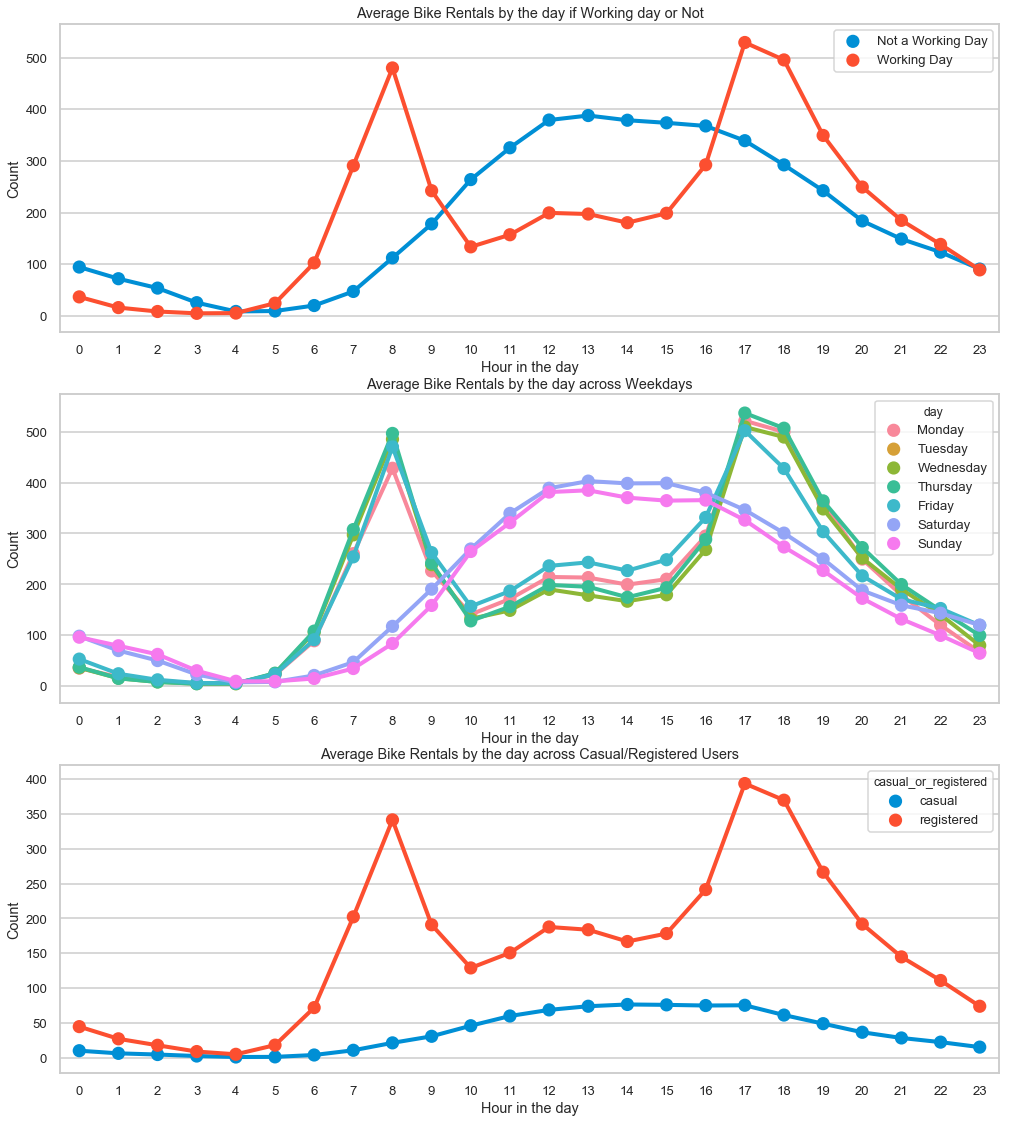

In [926]:
# Plots of average count across hour in a day for various categories

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(mydata.groupby(['workingday', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='hour', y='count', hue='workingday', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day if Working day or Not')

hue_order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(mydata.groupby(['day', 'hour'])['count'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='hour', y='count', hue='day', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Weekdays')

df_melt = pd.melt(frame=mydata, id_vars='hour', value_vars=['casual', 'registered'], value_name='count', var_name='casual_or_registered')
group_casual_hour = pd.DataFrame(df_melt.groupby(['hour', 'casual_or_registered'])['count'].mean()).reset_index()
sns.pointplot(data=group_casual_hour, x='hour', y='count', hue='casual_or_registered', ax=axes[2])
axes[2].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Casual/Registered Users')

plt.show()

#### Monthly Distribution

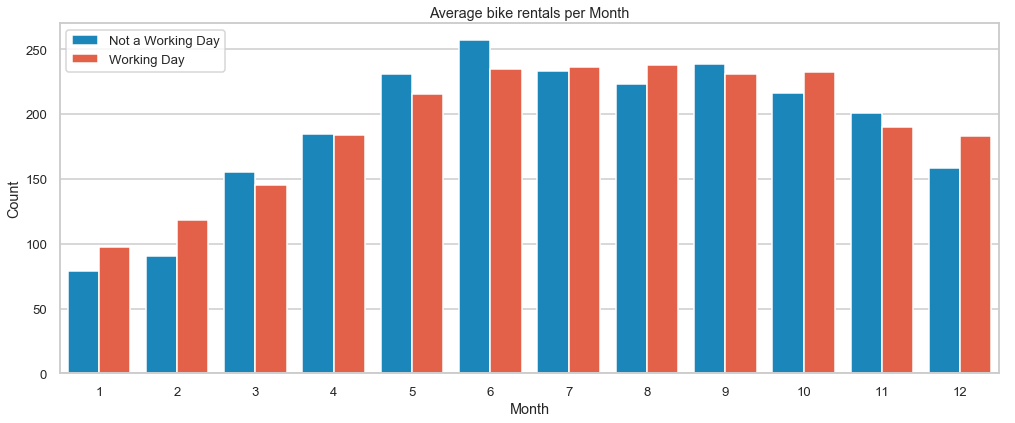

In [927]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(mydata.groupby(['month', 'workingday'])['count'].mean()).reset_index()
sns.barplot(data=group_month, x='month', y='count', hue='workingday', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

#### Few Observations
* Lesser number of outliers can be seen in the seaborn box plot across hours indicating that most of the outliers are due to highly varying distribution during the day
* Higher reservations can be seen at around 8am and 5pm (office hours) and close to 0 reservations very early in the morning
* From the above plot we can see the 2 patterns across the hours in a day in bike rentals
    * Working Day: First pattern where there is a peak in the rentals at around 8am and another at around 5pm. These correspond to working local bikers who typically are ``registered`` and go to work on ``working day`` which are ``Monday`` to ``Friday``
    * Non Working Day: Second pattern where there is more or less a uniform rentals across the day with a peak at around noon time. These correspond to probably tourists who typically are ``casual`` users who rent/drop off bikes uniformly during the day and tour the city of Washington on ``non working days`` which typically are ``Saturday`` and ``Sunday``
* Also, we can see that we have more bike rentals during the Fall (July to September) and Summer (April to June) Season.

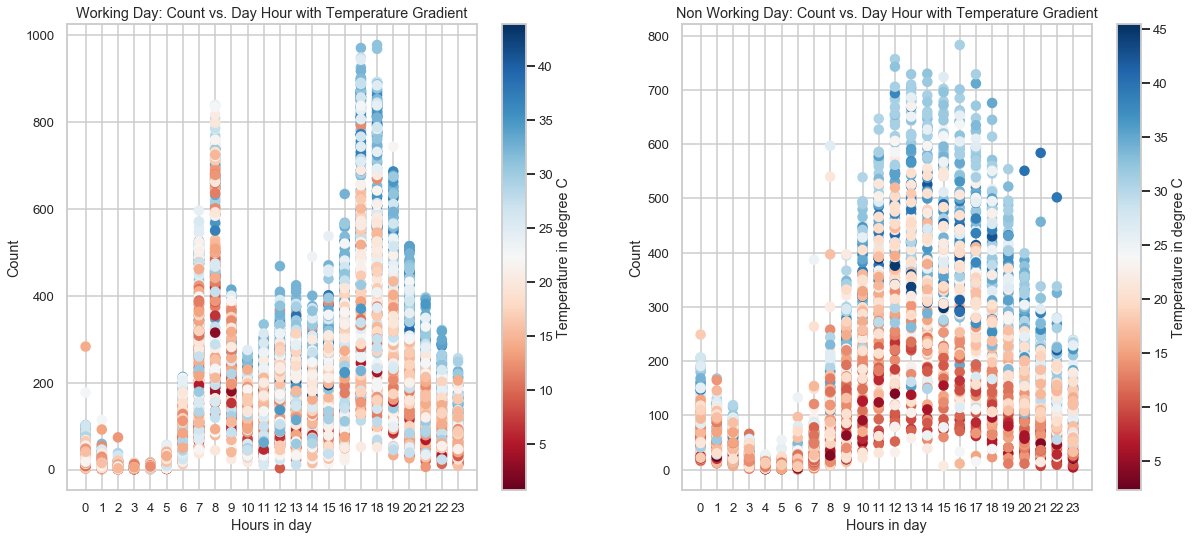

In [928]:
mydata_w = mydata[mydata.workingday==1]
mydata_nw = mydata[mydata.workingday==0]

fig = plt.figure(figsize=(18, 8))
# Working Day
axes = fig.add_subplot(1, 2, 1)
f = axes.scatter(mydata_w.hour, mydata_w['count'], c=mydata_w.atemp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

# Non Working Day
axes = fig.add_subplot(1, 2, 2)
f = axes.scatter(mydata_nw.hour, mydata_nw['count'], c=mydata_nw.atemp, cmap = 'RdBu')
axes.set(xticks = range(24), xlabel='Hours in day', ylabel='Count', title='Non Working Day: Count vs. Day Hour with Temperature Gradient')
cbar = plt.colorbar(f)
cbar.set_label('Temperature in degree C')

plt.show()

#### Observations
* From the above, we can see that in general, more people tend to prefer biking at moderate to high temperatures; however, if the temperature is too hot (darkest of the blue dots), there is a small decline in count

Let us use a histogram kind of a plot to confirm the above hypothesis

### Outliers Analysis 

#### Weather = 'Heavy Snow/Rain' outlier

In [929]:
heavy_weather_data = mydata.loc[mydata['weather']=='Heavy Snow/Rain', :]
print(heavy_weather_data.index)

DatetimeIndex(['2012-01-09 18:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [930]:
mydata['2012-01-09 08:00' : '2012-01-09 20:00']

season holiday workingday          weather   temp  \
datetime                                                                 
2012-01-09 08:00:00  Spring       0          1     Misty+Cloudy   9.02   
2012-01-09 09:00:00  Spring       0          1     Misty+Cloudy   9.02   
2012-01-09 10:00:00  Spring       0          1            Clear   9.84   
2012-01-09 11:00:00  Spring       0          1     Misty+Cloudy  10.66   
2012-01-09 12:00:00  Spring       0          1     Misty+Cloudy  10.66   
2012-01-09 13:00:00  Spring       0          1     Misty+Cloudy  10.66   
2012-01-09 14:00:00  Spring       0          1  Light Snow/Rain   9.02   
2012-01-09 15:00:00  Spring       0          1  Light Snow/Rain   9.02   
2012-01-09 16:00:00  Spring       0          1  Light Snow/Rain   9.02   
2012-01-09 17:00:00  Spring       0          1  Light Snow/Rain   9.02   
2012-01-09 18:00:00  Spring       0          1  Heavy Snow/Rain   8.20   
2012-01-09 19:00:00  Spring       0          1  Light Snow/Rain   8.20   
2012-01-09 20:00:00  Spring       0          1     Misty+Cloudy   8.20   

                      atemp  humidity  windspeed  casual  registered  count  \
datetime                                                                      
2012-01-09 08:00:00  12.880        55     6.0032      13         407    420   
2012-01-09 09:00:00  13.635        64     0.0000       9         188    197   
2012-01-09 10:00:00  14.395        60     0.0000      13          95    108   
2012-01-09 11:00:00  14.395        56     6.0032       6          82     88   
2012-01-09 12:00:00  13.635        56     7.0015      10          93    103   
2012-01-09 13:00:00  13.635        56     7.0015       3          77     80   
2012-01-09 14:00:00  11.365        75    11.0014       5          45     50   
2012-01-09 15:00:00  11.365        75    11.0014       5          64     69   
2012-01-09 16:00:00  12.880        87     6.0032       3          46     49   
2012-01-09 17:00:00  13.635        87     0.0000       5         147    152   
2012-01-09 18:00:00  11.365        86     6.0032       6         158    164   
2012-01-09 19:00:00  11.365        93     6.0032       3         187    190   
2012-01-09 20:00:00  11.365        86     6.0032       5         127    132   

                    month date hour     day  
datetime                                     
2012-01-09 08:00:00     1    9    8  Monday  
2012-01-09 09:00:00     1    9    9  Monday  
2012-01-09 10:00:00     1    9   10  Monday  
2012-01-09 11:00:00     1    9   11  Monday  
2012-01-09 12:00:00     1    9   12  Monday  
2012-01-09 13:00:00     1    9   13  Monday  
2012-01-09 14:00:00     1    9   14  Monday  
2012-01-09 15:00:00     1    9   15  Monday  
2012-01-09 16:00:00     1    9   16  Monday  
2012-01-09 17:00:00     1    9   17  Monday  
2012-01-09 18:00:00     1    9   18  Monday  
2012-01-09 19:00:00     1    9   19  Monday  
2012-01-09 20:00:00     1    9   20  Monday

From the above data, it appears like the weather was indeed bad at 6pm. It was bright and sunny at 10am and slowly got bad (weather = Misty->Light Snow->Heavy Snow) towards the end of the day. Also, there were several registered users who got to work that morning (407 commuters @ 8am). This explains why there were 158 registered commuters even under the worst of the weather conditions 

Since there is just one occurence of Heavy Snow/Rain Condition, let us replace the Heavy Snow/Rain label to Light Snow/Rain. 

In [931]:
# Replacing Heavy/Snow Rain condition with Light Snow/Rain
mydata.loc[mydata['weather']=='Heavy Snow/Rain', 'weather'] = 'Light Snow/Rain'
testdata.loc[testdata['weather']=='Heavy Snow/Rain', 'weather'] = 'Light Snow/Rain'

mydata['2012-01-09 18:00' : '2012-01-09 18:00']

season holiday workingday          weather  temp   atemp  \
datetime                                                                        
2012-01-09 18:00:00  Spring       0          1  Light Snow/Rain   8.2  11.365   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2012-01-09 18:00:00        86     6.0032       6         158    164     1   

                    date hour     day  
datetime                               
2012-01-09 18:00:00    9   18  Monday

#### Zscore based Outlier Pruning for every (Hours, Working day) groups

In [932]:
# Removing entries with zscore > 4

# Function to calculate zscore
def zscore(series): 
    return (series-series.mean())/series.std()

mydata['count_zscore'] = mydata.groupby(['hour', 'workingday'])['count'].transform(zscore)
outlier_idx = np.abs(mydata['count_zscore'])>4
outlier_data = mydata.loc[outlier_idx, :]
print('Shape of the outlier data entries: ', outlier_data.shape)
outlier_data

Shape of the outlier data entries:  (15, 16)


season holiday workingday       weather   temp   atemp  \
datetime                                                                      
2011-05-02 00:00:00  Summer       0          1         Clear  18.86  22.725   
2011-05-02 01:00:00  Summer       0          1         Clear  18.86  22.725   
2011-07-15 02:00:00    Fall       0          1         Clear  24.60  28.790   
2012-04-01 06:00:00  Summer       0          0  Misty+Cloudy  14.76  17.425   
2012-04-16 06:00:00  Summer       1          0         Clear  21.32  25.000   
2012-04-16 07:00:00  Summer       1          0         Clear  21.32  25.000   
2012-04-16 08:00:00  Summer       1          0  Misty+Cloudy  22.96  26.515   
2012-07-04 21:00:00    Fall       1          0         Clear  34.44  40.150   
2012-07-04 22:00:00    Fall       1          0         Clear  33.62  39.395   
2012-09-09 05:00:00    Fall       0          0         Clear  21.32  25.000   
2012-11-07 00:00:00  Winter       0          1  Misty+Cloudy  12.30  14.395   
2012-11-07 01:00:00  Winter       0          1  Misty+Cloudy  11.48  13.635   
2012-11-07 02:00:00  Winter       0          1  Misty+Cloudy  11.48  12.880   
2012-11-12 07:00:00  Winter       1          0         Clear  16.40  20.455   
2012-11-12 08:00:00  Winter       1          0         Clear  17.22  21.210   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2011-05-02 00:00:00        72     8.9981      68         109    177     5   
2011-05-02 01:00:00        72     8.9981      41          73    114     5   
2011-07-15 02:00:00        78    11.0014      16          22     38     7   
2012-04-01 06:00:00        76     8.9981       9          88     97     4   
2012-04-16 06:00:00        83    11.0014      10         123    133     4   
2012-04-16 07:00:00        83     8.9981      20         367    387     4   
2012-04-16 08:00:00        83    11.0014      48         549    597     4   
2012-07-04 21:00:00        53     8.9981     222         362    584     7   
2012-07-04 22:00:00        56    15.0013     175         327    502     7   
2012-09-09 05:00:00        77    12.9980      16          39     55     9   
2012-11-07 00:00:00        56    19.0012      49         234    283    11   
2012-11-07 01:00:00        61    16.9979       6          86     92    11   
2012-11-07 02:00:00        56    19.9995       6          68     74    11   
2012-11-12 07:00:00        87     0.0000      16         248    264    11   
2012-11-12 08:00:00        82    11.0014      50         490    540    11   

                    date hour        day  count_zscore  
datetime                                                
2011-05-02 00:00:00    2    0     Monday      5.328782  
2011-05-02 01:00:00    2    1     Monday      7.899886  
2011-07-15 02:00:00   15    2     Friday      4.248737  
2012-04-01 06:00:00    1    6     Sunday      4.227851  
2012-04-16 06:00:00   16    6     Monday      6.204331  
2012-04-16 07:00:00   16    7     Monday      7.784914  
2012-04-16 08:00:00   16    8     Monday      5.864166  
2012-07-04 21:00:00    4   21  Wednesday      4.970624  
2012-07-04 22:00:00    4   22  Wednesday      5.022732  
2012-09-09 05:00:00    9    5     Sunday      6.062216  
2012-11-07 00:00:00    7    0  Wednesday      9.355729  
2012-11-07 01:00:00    7    1  Wednesday      6.126384  
2012-11-07 02:00:00    7    2  Wednesday      9.422423  
2012-11-12 07:00:00   12    7     Monday      4.966377  
2012-11-12 08:00:00   12    8     Monday      5.174612

All the outliers occur mostly early in the morning or late at night. Let us prune out these outliers. These could be due to some late night shows or holiday or some party. 

In [933]:
# Removing outliers from mydata
mydata_without_outliers = mydata.loc[~outlier_idx, :]
print('Shape of data before outliner pruning: ', mydata.shape)
print('Shape of data after outlier pruning: ', mydata_without_outliers.shape)

Shape of data before outliner pruning:  (10886, 16)
Shape of data after outlier pruning:  (10871, 16)


In [934]:
# Dropping the zscore column
mydata_without_outliers = mydata_without_outliers.drop('count_zscore', axis=1)

In [935]:
mydata_without_outliers.head(n=3)

season holiday workingday weather  temp   atemp  \
datetime                                                               
2011-01-01 00:00:00  Spring       0          0   Clear  9.84  14.395   
2011-01-01 01:00:00  Spring       0          0   Clear  9.02  13.635   
2011-01-01 02:00:00  Spring       0          0   Clear  9.02  13.635   

                     humidity  windspeed  casual  registered  count month  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16     1   
2011-01-01 01:00:00        80        0.0       8          32     40     1   
2011-01-01 02:00:00        80        0.0       5          27     32     1   

                    date hour       day  
datetime                                 
2011-01-01 00:00:00    1    0  Saturday  
2011-01-01 01:00:00    1    1  Saturday  
2011-01-01 02:00:00    1    2  Saturday

### Correlation Analysis

#### Regression Plots w.r.t. Temperature, Humidity and Windspeed

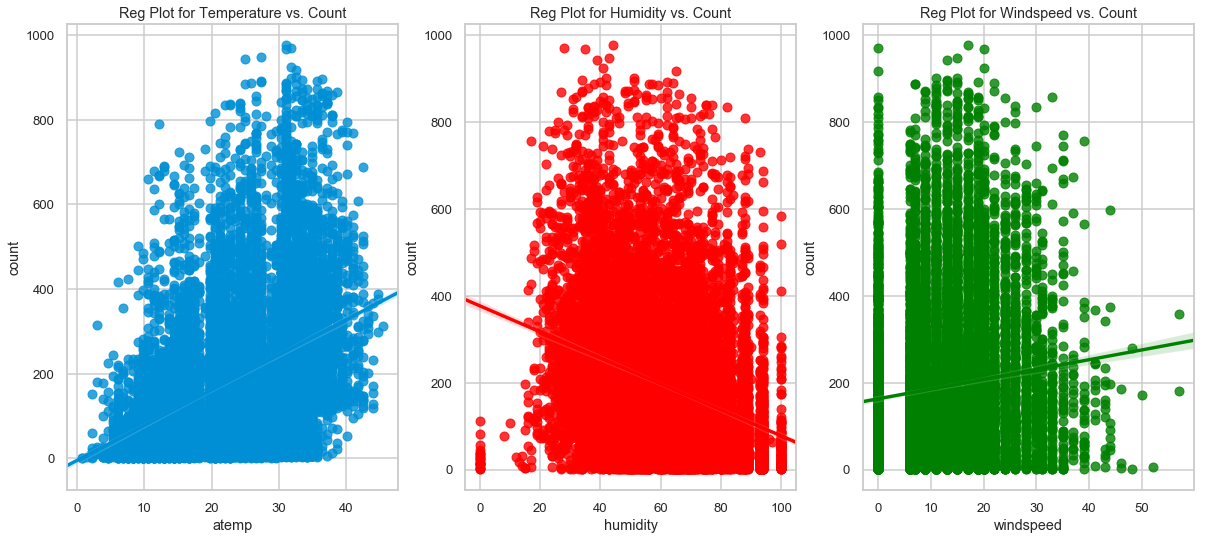

In [936]:
# Regression Plots with respect to Temperature, Humidity and Windspeed
fig = plt.figure(figsize=(18, 8))
axes = fig.add_subplot(1, 3, 1)
sns.regplot(data=mydata_without_outliers, x='atemp', y='count',ax=axes)
axes.set(title='Reg Plot for Temperature vs. Count')
axes = fig.add_subplot(1, 3, 2)
sns.regplot(data=mydata_without_outliers, x='humidity', y='count',ax=axes, color='r')
axes.set(title='Reg Plot for Humidity vs. Count')
axes = fig.add_subplot(1, 3, 3)
sns.regplot(data=mydata_without_outliers, x='windspeed', y='count',ax=axes, color='g')
axes.set(title='Reg Plot for Windspeed vs. Count')
plt.show()

#### Observations
* The above regplot indicates a positive correlation of count with temperature and windspeed and a negative correlation with humidity

#### Heatmap 

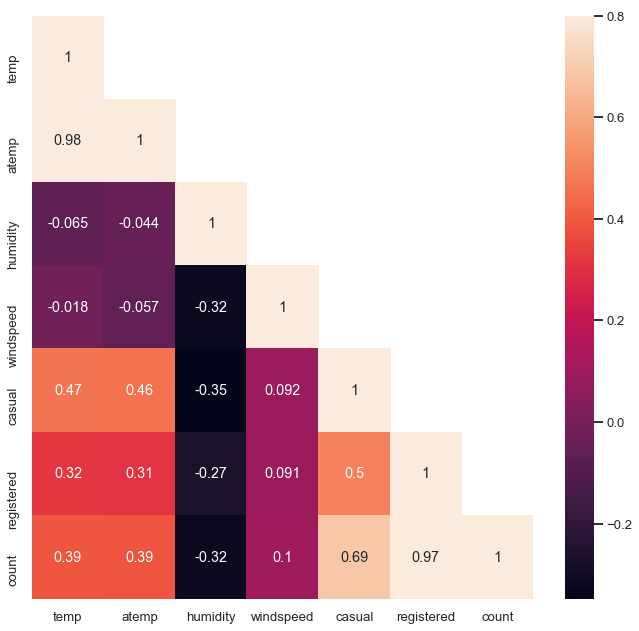

In [937]:
# Heatmap relative to all numeric columns
corr_matrix = mydata_without_outliers.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=0.8)
plt.show()

#### Inferences from the above heatmap
* temp (true temperature) and atemp (feels like temperature) are highly correlated as expected
* count is highly correlated with casual and registered as expected since count = casual + registered
* We see a positive correlation between count and temperature (as was seen in the regplot). This is probably only true for the range of temperatures provided
* We see a negative correlation between count and humidity. The more the humidity, the less people prefer to bike
* Not a great amount of correlation between humidity and temperature, though
* Count has a weak dependence on windspeed

### Feature Engineering - Part 2

We have lots of categorical columns. We will transform each relevant and important categorical columns into binary vector columns. Later drop all the columns that are not required (redundant or very low correlation). 

#### Summary of the column transformations
* Season: Month column has a direct mapping with season (Winter: January to March, Summer: April to June, Fall: July to September and Spring: October to December). Hence we will drop season column
* Holiday and 'day': workingday = weekday and not a holiday. Since we noticed that there were two kinds of bike rental behavoirs - during working days and not a working day, we will retain only the workingday column and drop 'day' and 'holiday' column
* Workingday: After observing the bike rental trend, we propose to build 2 separate models for 1. if it is a working day, and 2. if it is a non-working day. Hence, we can separate out the data based on  this column and drop the column
* Weather: Split weather column to weather_1, weather_2 and weather 3 (recall that we had relabelled all the weather = 4 data points to weather = 3 due to its sparseness). Drop weather_3 since it is a function of the rest of the weather columns
* Temp: temp and atemp are highly correlated. Hence retain only the atemp column (feels like temperature)
* Windspeed: Very poorly correlated with count. Hence drop this column
* Casual and registered: These are individual components of our to be predicted column (count). Hence drop these columns
* Month: Split month column to month_1, month_2, ..., month_12. Drop month_12 since it is a function of the rest of the month columns
* Date: Intuitively, there is should be no dependency on date. Hence drop this column
* Hour: Split hour column to hour_0, hour_1, ..., hour_23. Drop hour_23 since it is a function of the rest of the hour columns


In [938]:
# Using numbers to represent categorical data to transform the categorical columns
season_inv_dict = {'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4}
weather_inv_dict = {'Clear':1, 'Misty+Cloudy':2, 'Light Snow/Rain':3, 'Heavy Snow/Rain':4}
day_inv_dict = {'Monday':0, 'Teusday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

mydata_without_outliers['season'] = mydata_without_outliers['season'].map(season_inv_dict)
mydata_without_outliers['weather'] = mydata_without_outliers['weather'].map(weather_inv_dict)
mydata_without_outliers['day'] = mydata_without_outliers['day'].map(day_inv_dict)

testdata['season'] = testdata['season'].map(season_inv_dict)
testdata['weather'] = testdata['weather'].map(weather_inv_dict)
testdata['day'] = testdata['day'].map(day_inv_dict)

# Dropping columns from the provided data set that are either highly correlated with the existing columns: 
# season with month, holiday and day with workingday, temp with atemp
# or poorly correlated with the target column: windspeed and date
drop_columns_1 = ['season', 'holiday', 'temp', 'windspeed', 'date', 'day']
mydata_without_outliers = mydata_without_outliers.drop(drop_columns_1, axis=1)
testdata = testdata.drop(drop_columns_1, axis=1)
mydata_without_outliers.head(n=3)

workingday  weather   atemp  humidity  casual  registered  \
datetime                                                                        
2011-01-01 00:00:00          0        1  14.395        81       3          13   
2011-01-01 01:00:00          0        1  13.635        80       8          32   
2011-01-01 02:00:00          0        1  13.635        80       5          27   

                     count month hour  
datetime                               
2011-01-01 00:00:00     16     1    0  
2011-01-01 01:00:00     40     1    1  
2011-01-01 02:00:00     32     1    2

In [939]:
# Transforming all the categorical columns into binary columns
month=pd.get_dummies(mydata_without_outliers['month'], prefix='month')
weather=pd.get_dummies(mydata_without_outliers['weather'], prefix='weather')
hour=pd.get_dummies(mydata_without_outliers['hour'], prefix='hour')
mydata_train=pd.concat([mydata_without_outliers, weather, month, hour],axis=1)

month=pd.get_dummies(testdata['month'], prefix='month')
weather=pd.get_dummies(testdata['weather'], prefix='weather')
hour=pd.get_dummies(testdata['hour'], prefix='hour')
mydata_test=pd.concat([testdata, weather, month, hour],axis=1)

mydata_train.columns

Index(['workingday', 'weather', 'atemp', 'humidity', 'casual', 'registered',
       'count', 'month', 'hour', 'weather_1', 'weather_2', 'weather_3',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [940]:
# Dropping columns and the last binary vector column 
drop_columns_2 = ['weather', 'month', 'hour', 'weather_3', 'month_12', 'hour_23']

mydata_train = mydata_train.drop(drop_columns_2+['casual', 'registered'], axis=1)
mydata_test = mydata_test.drop(drop_columns_2, axis=1)
mydata_without_outliers = mydata_without_outliers.drop(['casual', 'registered'], axis=1)

mydata_train.columns

Index(['workingday', 'atemp', 'humidity', 'count', 'weather_1', 'weather_2',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22'],
      dtype='object')

## Model Fitting

Since the bike rental trend is quite different between working and non-working day, we try the following two ways to solve this problem
1. Build 2 separate models - 1. for working day, and 2. for non-working day.  
2. Build a single model using workingday as one of the features


### Prepare the data

First split the labelled data provided into internal training and testing set. Kaggle has held out data from 20th to the end of the month (for every month) as test set. Following a similar approach, split the labelled data (mydata_train) into 
1. Training set, model_train
    * This will contain data of from the 1st to 15th of every month 
    * This will be used to train our model
2. Testing set, model_test
    * This will contain data from 16th to 19th of every month 
    * This will be used to test our model

The final test data for which labels (count) have not been provided corresponds to 20th to the end of every month

In [941]:
model_train, model_test = mydata_train[mydata_train.index.day<15], mydata_train[mydata_train.index.day>=15]
model_train2, model_test2 = mydata_without_outliers[mydata_without_outliers.index.day<15], mydata_without_outliers[mydata_without_outliers.index.day>=15]

# Separating out the working an non-working data from the training set 
model_train_w = model_train[model_train['workingday']==1]
model_train_nw = model_train[model_train['workingday']==0]
model_train2_w = model_train2[model_train2['workingday']==1]
model_train2_nw = model_train2[model_train2['workingday']==0]

model_test_w = model_test[model_test['workingday']==1]
model_test_nw = model_test[model_test['workingday']==0]
model_test2_w = model_test2[model_test2['workingday']==1]
model_test2_nw = model_test2[model_test2['workingday']==0]

# Dropping workingday column 
model_train_w = model_train_w.drop('workingday', axis=1)
model_train_nw = model_train_nw.drop('workingday', axis=1)
model_train2_w = model_train2_w.drop('workingday', axis=1)
model_train2_nw = model_train2_nw.drop('workingday', axis=1)

model_test_w = model_test_w.drop('workingday', axis=1)
model_test_nw = model_test_nw.drop('workingday', axis=1)
model_test2_w = model_test2_w.drop('workingday', axis=1)
model_test2_nw = model_test2_nw.drop('workingday', axis=1)

In [942]:
# Contains Binary Vector Form of features (Obtained from OneHotEncoder transformed categorical feature)
X, X_w, X_nw = model_train.drop('count', axis=1), model_train_w.drop('count', axis=1), model_train_nw.drop('count', axis=1)
y, y_w, y_nw = model_train['count'], model_train_w['count'], model_train_nw['count']
logy, logy_w, logy_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

Xtest, Xtest_w, Xtest_nw = model_test.drop('count', axis=1), model_test_w.drop('count', axis=1), model_test_nw.drop('count', axis=1)
ytest, ytest_w, ytest_nw = model_test['count'], model_test_w['count'], model_test_nw['count']
logytest, logytest_w, logytest_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

# Contains Categorical features instead of the Binary Vector Form
X2, X2_w, X2_nw = model_train2.drop('count', axis=1), model_train2_w.drop('count', axis=1), model_train2_nw.drop('count', axis=1)
y2, y2_w, y2_nw = model_train2['count'], model_train2_w['count'], model_train2_nw['count']
logy2, logy2_w, logy2_nw = np.log1p(y2), np.log1p(y2_w), np.log1p(y2_nw)

Xtest2, Xtest2_w, Xtest2_nw = model_test2.drop('count', axis=1), model_test2_w.drop('count', axis=1), model_test2_nw.drop('count', axis=1)
ytest2, ytest2_w, ytest2_nw = model_test2['count'], model_test2_w['count'], model_test2_nw['count']
logytest2, logytest2_w, logytest2_nw = np.log1p(y), np.log1p(y_w), np.log1p(y_nw)

# Data Frame to store all the RMSLE scores for various algorithms
algo_score = pd.DataFrame()
algo_score.index.name = 'Modelling Algo'
algo_score['Train RMSLE (Working Day)'] = None
algo_score['Train RMSLE (Non Working Day)'] = None
algo_score['Train RMSLE (Average)'] = None
algo_score['Test RMSLE (Working Day)'] = None
algo_score['Test RMSLE (Non Working Day)'] = None
algo_score['Test RMSLE (Average)'] = None
algo_score['Hyperparameters-Working'] = None
algo_score['Hyperparameters-Non Working'] = None

**Defining few functions which we would call for every model**

In [ ]:
from sklearn.metrics import make_scorer

# Metric used to measure the model (Root Mean Square Log Error)
def rmsle(y_actual, y_pred):
    log1 = np.nan_to_num(np.array([np.log1p(v) for v in y_pred]))
    log2 = np.nan_to_num(np.array([np.log1p(v) for v in y_actual]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# RMSLE function with inputs in log form. Used for CrossValidation scoring
def rmsle_log(logy_actual, logy_pred):
    calc = (logy_actual - logy_pred) ** 2
    return np.sqrt(np.mean(calc))
rmsle_cv = make_scorer(rmsle_log, greater_is_better=False)


In [943]:
# Plots True vs. Predictied count values in a particular time interval
def plot_true_vs_pred (y_w_actual, y_nw_actual, y_w_pred, y_nw_pred, algo, t_from, t_to):
    fig = plt.figure(figsize=(18, 16))
    
    # Working day plot
    axes = fig.add_subplot(2, 1, 1)
    axes.plot(y_w_actual[t_from:t_to], label='Actual', marker='.', markersize=15)
    axes.plot(y_w_pred[t_from:t_to], label='Predicted', marker='.', markersize=15)
    axes.set(xlabel='Time', ylabel='Count', title='{0} Model for Working Day: Count between time {1} and {2}'.format(algo, t_from, t_to))
    axes.legend()

    # Non working day plot
    axes = fig.add_subplot(2, 1, 2)
    axes.plot(y_nw_actual[t_from:t_to], label='Actual', marker='.', markersize=15)
    axes.plot(y_nw_pred[t_from:t_to], label='Predicted', marker='.', markersize=15)
    axes.set(xlabel='Time', ylabel='Count', title='{0} Model for Non Working Day: Count between time {1} and {2}'.format(algo, t_from, t_to))
    axes.legend()
    plt.show()

In [944]:
# Customized Function to fit/predict training and testing data for:
# 1. working and non-working days or 2. combined working and non-working days
# Output: 1. rmsle for training, test data for working, non-working and combined 
#         2. predicted y for training, test for working/non-working or combined
def model_fit (model_w, X_tr_w, X_t_w, y_tr_w, y_t_w, model_nw=None, X_tr_nw=None, X_t_nw=None, y_tr_nw=None, y_t_nw=None):
    ''' Case 1: If separate models for Working day and non-working day
    model_w, model_nw = Models for Working and non-working days, respectively
    X_tr_w, y_tr_w = Training data set for Working days
    X_t_w, y_t_w = Testing data set for Working days
    X_tr_nw, y_tr_nw = Training data set for Non Working days
    X_t_nw, y_t_nw = Testing data set for Non Working days 
    
    Case 2: If single model for working day and non-working day 
    model_w = Single Model for Working and non-working days
    X_tr_w, y_tr_w = Training data set containing both Working and non-working days (feature list must contain 'workingday')
    X_t_w, y_t_w = Testing data set containing both Working and non-working days'''
    
    # Working Day Modeling of Single Model for Working and Non-Working Day
    model_w.fit(X_tr_w, np.log1p(y_tr_w))
    logy_tr_w_predict = model_w.predict(X_tr_w)
    logy_t_w_predict = model_w.predict(X_t_w)
    
    y_tr_w_predict = np.expm1(logy_tr_w_predict)
    y_t_w_predict = np.expm1(logy_t_w_predict)
    
    rmsle_w_tr = rmsle(y_tr_w, y_tr_w_predict)
    rmsle_w_t = rmsle(y_t_w, y_t_w_predict)
    
    if model_nw is None:
        # Single Model for working and non-working days. The feature list in X should have workingday column
        [rmsle_avg_tr, rmsle_avg_t] = [rmsle_w_tr, rmsle_w_t] # The RMSLE computed by the first model is the overall RMSLE
        rmsle_w_tr = rmsle(y_tr_w[X_tr_w.workingday==1], y_tr_w_predict[X_tr_w.workingday==1])
        rmsle_nw_tr = rmsle(y_tr_w[X_tr_w.workingday==0], y_tr_w_predict[X_tr_w.workingday==0])
        rmsle_w_t = rmsle(y_t_w[X_t_w.workingday==1], y_t_w_predict[X_t_w.workingday==1])
        rmsle_nw_t = rmsle(y_t_w[X_t_w.workingday==0], y_t_w_predict[X_t_w.workingday==0])
        y_tr_nw_predict, y_t_nw_predict = None, None
    else:
        # Non-working day Modeling
        model_nw.fit(X_tr_nw, np.log1p(y_tr_nw))
        logy_tr_nw_predict = model_nw.predict(X_tr_nw)
        logy_t_nw_predict = model_nw.predict(X_t_nw)

        y_tr_nw_predict = np.expm1(logy_tr_nw_predict)
        y_t_nw_predict = np.expm1(logy_t_nw_predict)

        rmsle_nw_tr = rmsle(y_tr_nw, y_tr_nw_predict)
        rmsle_nw_t = rmsle(y_t_nw, y_t_nw_predict)

        # Combined RMSLE
        [rmsle_avg_tr, rmsle_avg_t] = [rmsle(np.concatenate([y_tr_w, y_tr_nw]), np.concatenate([y_tr_w_predict, y_tr_nw_predict])), 
                                       rmsle(np.concatenate([y_t_w, y_t_nw]), np.concatenate([y_t_w_predict, y_t_nw_predict]))]
    
    rmsle_all = [rmsle_w_tr, rmsle_nw_tr, rmsle_avg_tr, rmsle_w_t, rmsle_nw_t, rmsle_avg_t]
    y_pred_all = [y_tr_w_predict, y_t_w_predict, y_tr_nw_predict, y_t_nw_predict]
    
    return(rmsle_all, y_pred_all)
    

### 1. Linear Regression

**Model Fit+Predict**

In [945]:
from sklearn.linear_model import LinearRegression
lreg_w, lreg_nw = LinearRegression(), LinearRegression()

rmsle_summary, y_predict_summary = model_fit(lreg_w, X_w, Xtest_w, y_w, ytest_w, lreg_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
param_summary = ['', '']

algo_score.loc['Linear Regression'] = rmsle_summary+param_summary
algo_score.loc[['Linear Regression']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                                
Linear Regression                   0.415613                       0.430999   

                   Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                       
Linear Regression               0.420488                  0.405675   

                   Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                          
Linear Regression                      0.492574              0.436724   

                  Hyperparameters-Working Hyperparameters-Non Working  
Modelling Algo                                                         
Linear Regression

**Observations**
* Not an overfit model - both train and test RMSLE are more or less similar
* A good initial model

**Prediction Plot for Test data in a month (last 5 days of a month)**

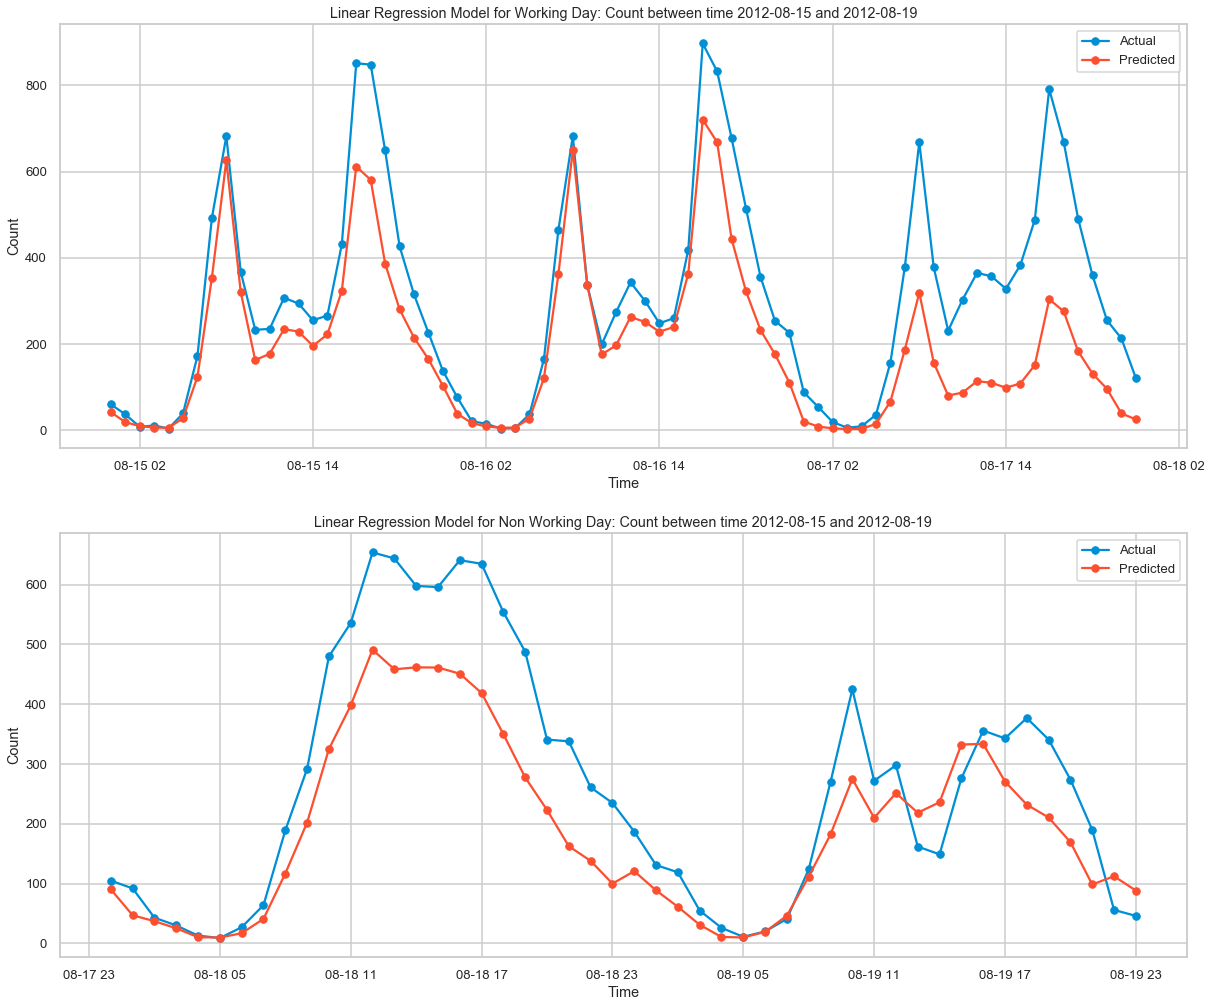

In [946]:
# Linear Regression Plot: True vs. Predicted for one week 
t_from, t_to = '2012-08-15', '2012-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Linear Regression', t_from, t_to)

In [947]:
# Features and the Estimated Linear Regression Coefficients obtained for Working day and Non-working day models
df_coeff = pd.DataFrame({'features': X_w.columns, 'Lin_Coeff_Working': lreg_w.coef_, 'Lin_Coeff_Non_Working': lreg_nw.coef_})

### 2. Regularization Model - Ridge 

**Hyperparameter Tuning**

In [948]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
ridge_w = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
ridge_w.fit(X_w, logy_w)
print('Best alpha for Working Day Ridge Regression Model: {}'.format(ridge_w.best_params_))
ridge_nw = GridSearchCV(Ridge(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
ridge_nw.fit(X_nw, logy_nw)
print('Best alpha for Non Working Day Ridge Regression Model: {}'.format(ridge_nw.best_params_))

Best alpha for Working Day Ridge Regression Model: {'alpha': 10}
Best alpha for Non Working Day Ridge Regression Model: {'alpha': 10}


**Model Fit + Predict**

In [949]:
rmsle_summary, y_predict_summary = model_fit(ridge_w, X_w, Xtest_w, y_w, ytest_w, ridge_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
param_summary = [ridge_w.best_params_, ridge_nw.best_params_]

algo_score.loc['Ridge Regression'] = rmsle_summary+param_summary
algo_score.loc[['Ridge Regression']]


Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                               
Ridge Regression                   0.420662                        0.44637   

                  Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                      
Ridge Regression               0.428872                  0.410693   

                  Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                         
Ridge Regression                      0.516091              0.448776   

                 Hyperparameters-Working Hyperparameters-Non Working  
Modelling Algo                                                        
Ridge Regression           {'alpha': 10}               {'alpha': 10}

**Obsevations**
* Similar performance as Linear Regression. 

**Prediction Plot for Test data in a month (last 5 days of a month)**

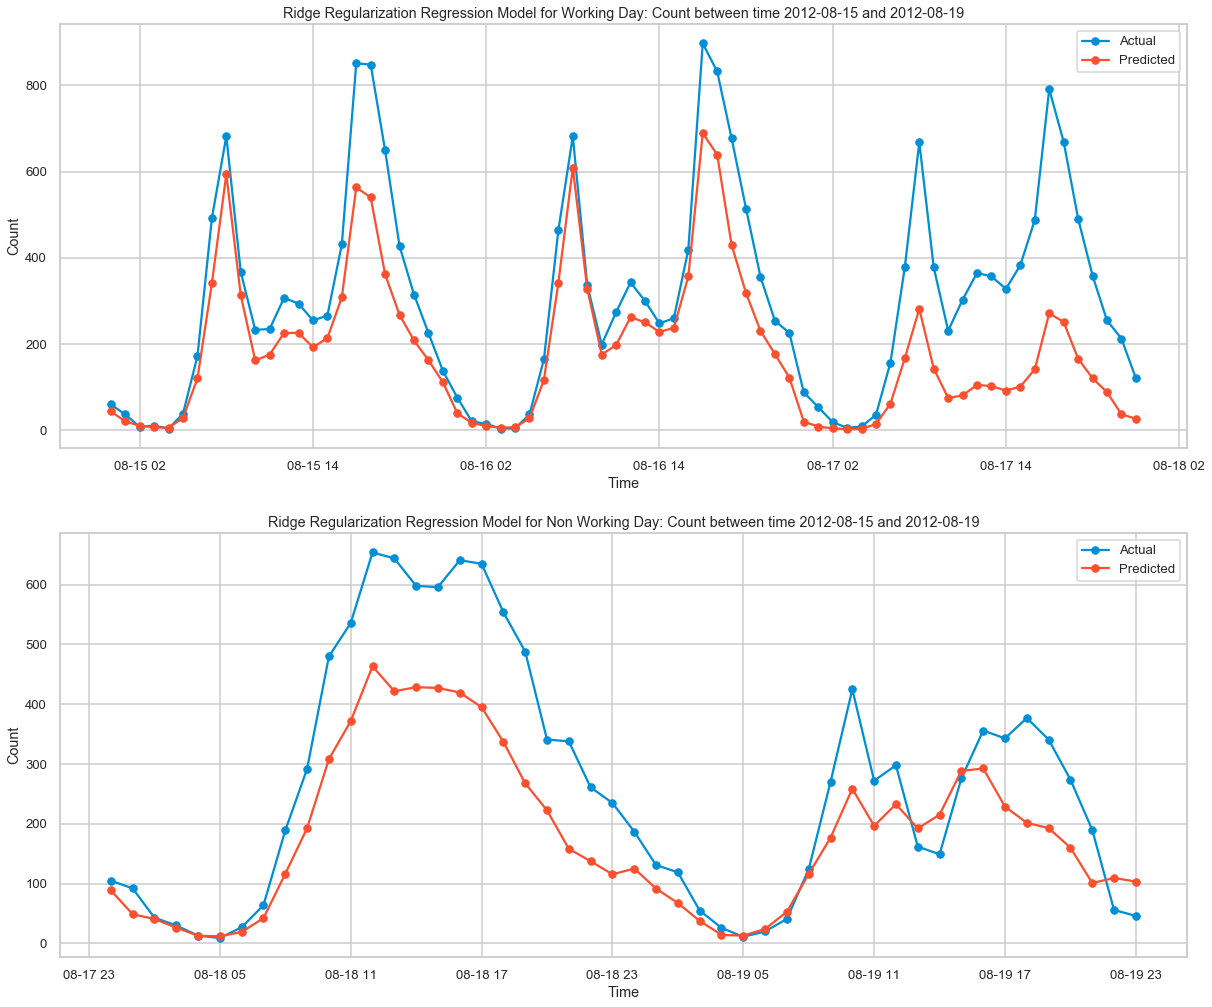

In [950]:
# Ridge Regression Plot: True vs. Predicted for one month 
t_from, t_to = '2012-08-15', '2012-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Ridge Regularization Regression', t_from, t_to)

In [951]:
# Features and the Estimated Linear Regression Coefficients obtained for Working day and Non-working day models
df_coeff['Ridge_Coeff_Working'] = ridge_w.best_estimator_.coef_
df_coeff['Ridge_Coeff_Non_Working'] = ridge_nw.best_estimator_.coef_

### 3. Regularization Model - Lasso 

**Hyperparameter Tuning**

In [952]:
# Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]}
lasso_w = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
lasso_w.fit(X_w, logy_w)
print('Best alpha for Working Day Lasso Regression Model: {}'.format(lasso_w.best_params_))

lasso_nw = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
lasso_nw.fit(X_nw, logy_nw)
print('Best alpha for Non Working Day Lasso Regression Model: {}'.format(lasso_nw.best_params_))

Best alpha for Working Day Lasso Regression Model: {'alpha': 0.1}
Best alpha for Non Working Day Lasso Regression Model: {'alpha': 0.5}


**Model Fit + Predict**

In [953]:
rmsle_summary, y_predict_summary = model_fit(lasso_w, X_w, Xtest_w, y_w, ytest_w, lasso_nw, X_nw, Xtest_nw, y_nw, ytest_nw)
param_summary = [lasso_w.best_params_, lasso_nw.best_params_]

algo_score.loc['Lasso Regression'] = rmsle_summary+param_summary
algo_score.loc[['Lasso Regression']]

Train RMSLE (Working Day)  Train RMSLE (Non Working Day)  \
Modelling Algo                                                               
Lasso Regression                   1.311302                        1.05751   

                  Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                      
Lasso Regression               1.237495                   1.29106   

                  Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                         
Lasso Regression                       1.11838              1.235888   

                 Hyperparameters-Working Hyperparameters-Non Working  
Modelling Algo                                                        
Lasso Regression          {'alpha': 0.1}              {'alpha': 0.5}

**Observations**
* Very poor performance. It probably zeros out several features

**Prediction Plot for Test data in a month (last 5 days of a month)**

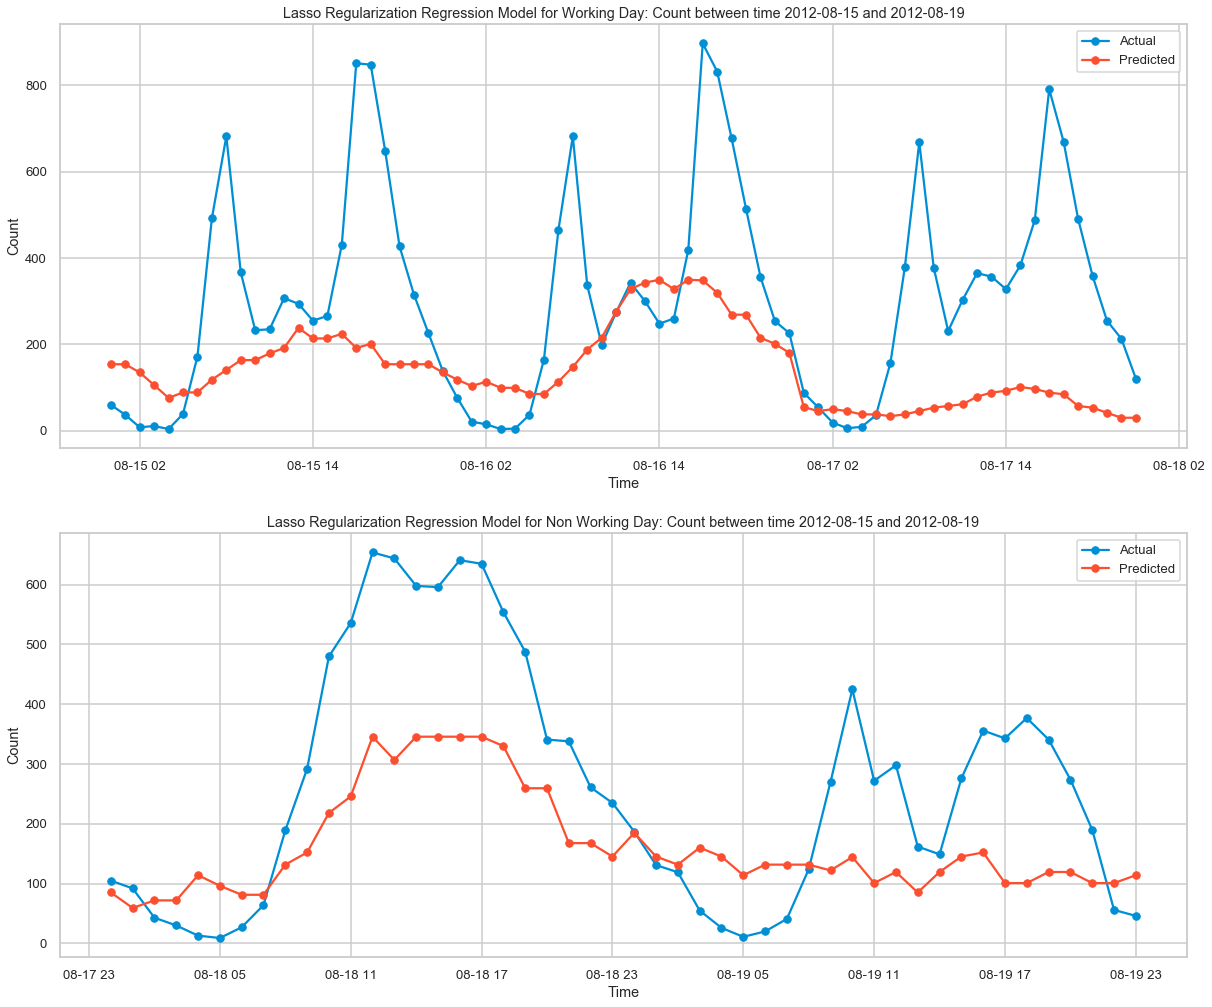

In [954]:
# Lasso Regression Plot: True vs. Predicted for one month 
t_from, t_to = '2012-08-15', '2012-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Lasso Regularization Regression', t_from, t_to)

In [955]:
# Features and the Estimated Linear Regression Coefficients obtained for Working day and Non-working day models
df_coeff['Lasso_Coeff_Working'] = lasso_w.best_estimator_.coef_
df_coeff['Lasso_Coeff_Non_Working'] = lasso_nw.best_estimator_.coef_

### Feature Coefficient plots: Linear vs. Ridge vs. Lasso Regression Models

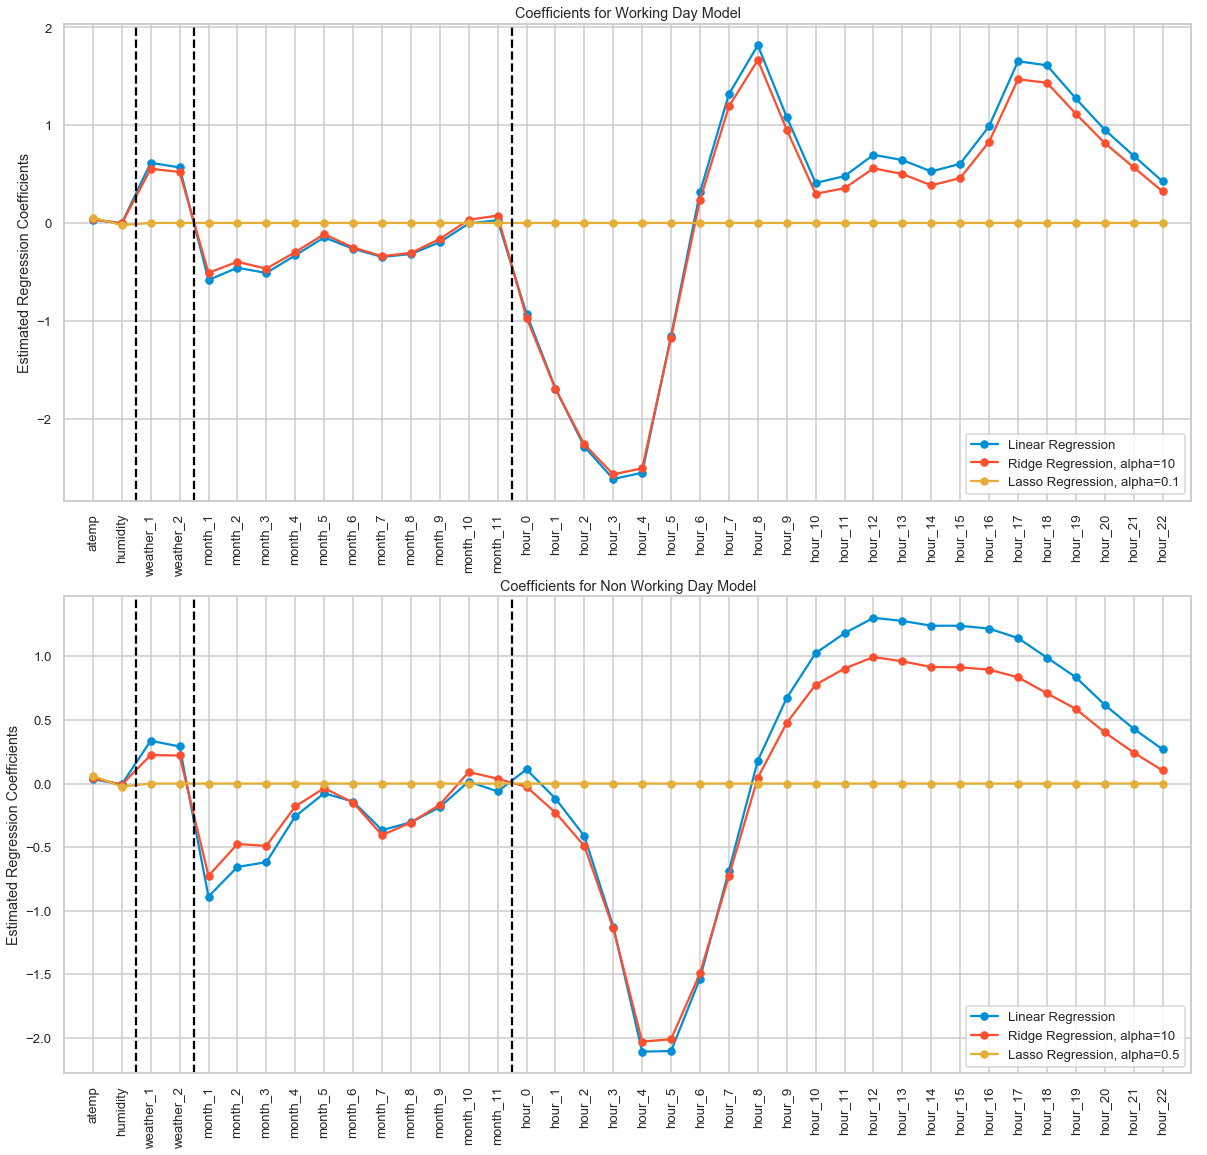

In [956]:
# Plotting the feature coefficients for Linear, Ridge and Lasso Regression Models
fig = plt.figure(figsize=(18, 18))
    
# Working day plot
axes = fig.add_subplot(2, 1, 1)
axes.plot(df_coeff.Lin_Coeff_Working, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff_Working, label='Ridge Regression, alpha={}'.format(ridge_w.best_params_['alpha']), marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff_Working, label='Lasso Regression, alpha={}'.format(lasso_w.best_params_['alpha']), marker='.', markersize=15)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
plt.xticks(range(len(df_coeff.Lin_Coeff_Working)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for Working Day Model')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff_Working)])
axes.legend()

axes = fig.add_subplot(2, 1, 2)
axes.plot(df_coeff.Lin_Coeff_Non_Working, label='Linear Regression', marker='.', markersize=15)
axes.plot(df_coeff.Ridge_Coeff_Non_Working, label='Ridge Regression, alpha={}'.format(ridge_nw.best_params_['alpha']), marker='.', markersize=15)
axes.plot(df_coeff.Lasso_Coeff_Non_Working, label='Lasso Regression, alpha={}'.format(lasso_nw.best_params_['alpha']), marker='.', markersize=15)
axes.axvline(2-0.5,  c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
plt.xticks(range(len(df_coeff.Lin_Coeff_Working)), df_coeff.features, rotation=90)
axes.set(ylabel='Estimated Regression Coefficients', title='Coefficients for Non Working Day Model')
axes.set(xlim=[-1, len(df_coeff.Lin_Coeff_Working)])
axes.legend()

plt.show()

#### Observations 
* As expected from the minimizing function, Linear Regression coefficients are most agressive (highest magnitude). Ridge Regression coefficients closely follows Linear Regression. And Lasso more or less nullifies most of the coefficients. 
* Lasso model provides a non-zero value only for atemp and humidity and hour_3 for working day model
* From the Linear and Ridge coefficient plots, we can see that maximum dependency on the bike rental count are the hour in the day (highest coefficient magnitudes). Negative values of coefficient for early morning hours and positive values with greater magnitude during peak hours of the respective models. 
    * Working day coefficent has highest positive coefficient values at 8am and 5pm
    * Non-working day coefficients has a single peak across hours ~ 12 noon (as observed from our earlier plots)
* Weather_1 and weather_2 have positive coefficient value, indicating a negative bias for weather_3 (light snow/rain). Note that if weather=3, then weather_1 and weather_2 = 0. Hence effective weather_3 coefficient = 0
* Though the coefficient value for atemp and humidity is low compared to the others, the range of these values are higher too. 
* The absolute value of the coefficients are higher for months 5, 6, 10, 11, 12 indicating higher bike rentals during that month. 

### 4. Ensemble Model - Random Forest

### a. Using Single Model for Working and Non-working days
Since Random Forest Regression predicts based on decision tree, we expect it to handle categorical features including hours, months, working and non-working day gracefully. Let us start off by including those features into our model (instead of the using the transformed features + 2 models for working and non-working) and see its performance first. It would be a simple single model and easier to analyze

In [957]:
# Head of the Traning data
X2.head(n=3)

workingday  weather   atemp  humidity month hour
datetime                                                            
2011-01-01 00:00:00          0        1  14.395        81     1    0
2011-01-01 01:00:00          0        1  13.635        80     1    1
2011-01-01 02:00:00          0        1  13.635        80     1    2

**Hyperparameter Tuning**  
Procedure - tuning 1 parameter at a time
1. First obtain n_estimators using default values of the remaining parameters
2. Tune for the max_features using the best n_estimators
3. Tune for min_samples_leaf using the best n_estimators and max_features
4. Tune for max_depth using the best n_estimators, max_features and min_samples_leaf
5. Tune for min_samples_split using the best n_estimators, max_features, min_samples_leaf and max_depth

In [958]:
## Random Forest Regression Hyperparameter tuning using Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators': [50, 100, 200, 500, 1000, 2000, 5000]}
#rf_main = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_main.fit(X2, logy2)

#param_grid = {'n_estimators': [500], 'max_features':['auto', 'sqrt', 'log2']}
#rf_main = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_main.fit(X2, logy2)

#param_grid = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[1, 3, 7, 10, 20, 50]}
#rf_main = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_main.fit(X2, logy2)

#param_grid = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[7], 'max_depth':[5, 8, 10, 20, 30, 40, 50, 70]}
#rf_main = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_main.fit(X2, logy2)

#param_grid = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[7], 'max_depth':[10], 'min_samples_split':[0.0001, 0.001, 0.002, 0.005, 0.01]}
#rf_main = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_main.fit(X2, logy2)

#print('Best parameters for Random Forest Regression Model: {}'.format(rf_main.best_params_))


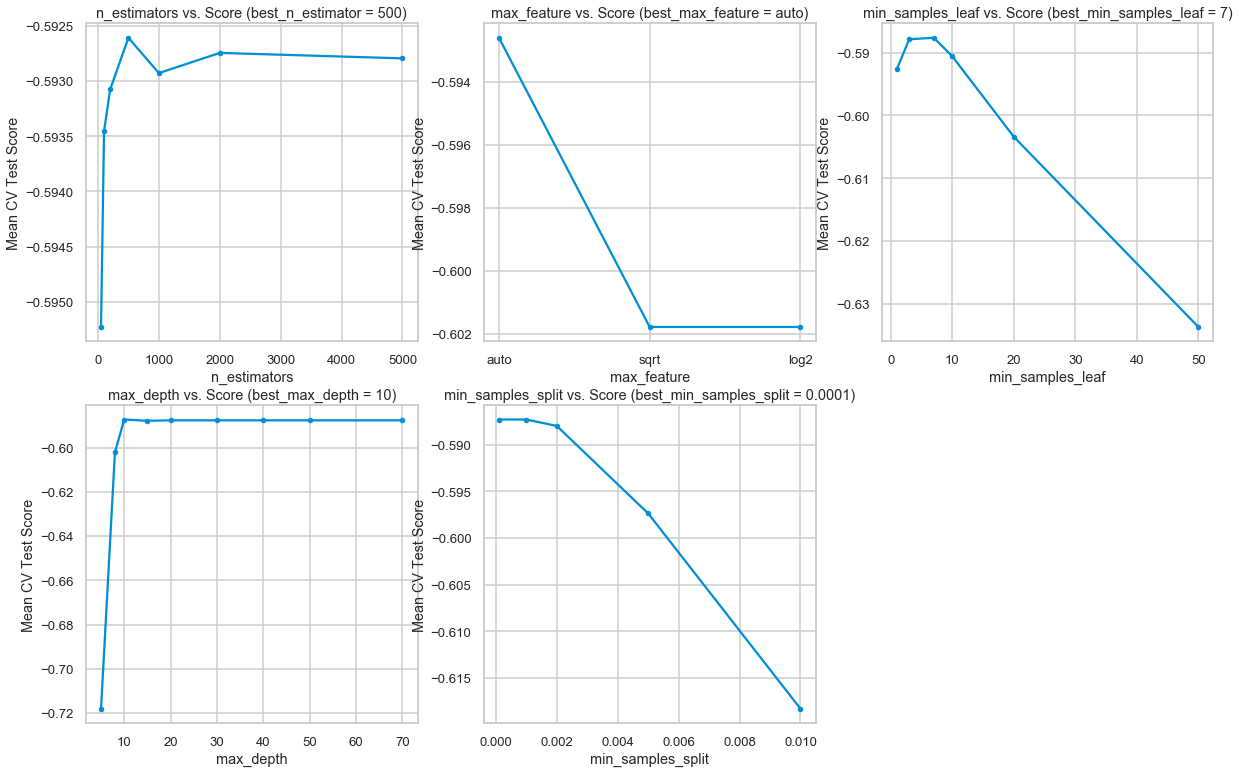

In [959]:
# All the below results are obtained from the above GridSearchCV hyperparamter tuning
fig=plt.figure(figsize=(18, 12))

n_est_array = [50, 100, 200, 500, 1000, 2000, 5000]
n_est_cv_score = [-0.59522862, -0.59345376, -0.59307606, -0.59260841, -0.59292831,-0.59274538, -0.59279494]
axes=fig.add_subplot(2, 3, 1)
axes.plot(n_est_array, n_est_cv_score, marker='.')
axes.set(xlabel='n_estimators', ylabel='Mean CV Test Score', title='n_estimators vs. Score (best_n_estimator = 500)')

max_feature_array = ['auto', 'sqrt', 'log2']
max_feature_cv_score = [-0.59260841, -0.60178303, -0.60178303]
axes=fig.add_subplot(2, 3, 2)
axes.plot(range(3), max_feature_cv_score, marker='.')
plt.xticks(range(3), max_feature_array)
axes.set(xlabel='max_feature', ylabel='Mean CV Test Score', title='max_feature vs. Score (best_max_feature = auto)')

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score = [-0.59260841, -0.58788348, -0.58764415, -0.59060404, -0.60340495,-0.63367843]
axes=fig.add_subplot(2, 3, 3)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score, marker='.')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score (best_min_samples_leaf = 7)')

max_depth_array = [5, 8, 10, 15, 20, 30, 40, 50, 70]
max_depth_cv_score = [-0.71808668, -0.60209726, -0.58727382, -0.58785334, -0.58764068, -0.58764415, -0.58764415, -0.58764415, -0.58764415]
axes=fig.add_subplot(2, 3, 4)
axes.plot(max_depth_array, max_depth_cv_score, marker='.')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score (best_max_depth = 10)')

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score = [-0.58727382, -0.58727382, -0.58796633, -0.59735637, -0.61832167]
axes=fig.add_subplot(2, 3, 5)
axes.plot(min_samples_split_array, min_samples_split_cv_score, marker='.')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score (best_min_samples_split = 0.0001)')

plt.show()

**Model Fit + Predict**

In [960]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Best parameters obtained via GridSearchCV above
best_n_estimators, best_max_features = 500, 'auto'
best_min_samples_leaf, best_max_depth = 7, 10

rfa = RandomForestRegressor(n_estimators = best_n_estimators, max_features = best_max_features, 
                           min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state=42)


rmsle_summary, y_predict_summary = model_fit(rfa, X2, Xtest2, y2, ytest2)
param_summary = ['n_estimator={}, max_features={}'.format(best_n_estimators, best_max_features), 
                'n_estimator={}, max_features={}'.format(best_n_estimators, best_max_features)]

algo_score.loc['Random Forest-Categorical+Single'] = rmsle_summary+param_summary
algo_score.loc[['Random Forest-Categorical+Single']]

Train RMSLE (Working Day)  \
Modelling Algo                                                
Random Forest-Categorical+Single                   0.354905   

                                  Train RMSLE (Non Working Day)  \
Modelling Algo                                                    
Random Forest-Categorical+Single                       0.382949   

                                  Train RMSLE (Average)  \
Modelling Algo                                            
Random Forest-Categorical+Single               0.363913   

                                  Test RMSLE (Working Day)  \
Modelling Algo                                               
Random Forest-Categorical+Single                  0.399774   

                                  Test RMSLE (Non Working Day)  \
Modelling Algo                                                   
Random Forest-Categorical+Single                      0.490854   

                                  Test RMSLE (Average)  \
Modelling Algo                                           
Random Forest-Categorical+Single              0.432436   

                                             Hyperparameters-Working  \
Modelling Algo                                                         
Random Forest-Categorical+Single  n_estimator=500, max_features=auto   

                                         Hyperparameters-Non Working  
Modelling Algo                                                        
Random Forest-Categorical+Single  n_estimator=500, max_features=auto

**Observations**
* We see marginal gain (Test RMSLE reduced to 0.43 from 0.44) over the linear models

**Feature Importance Plot**

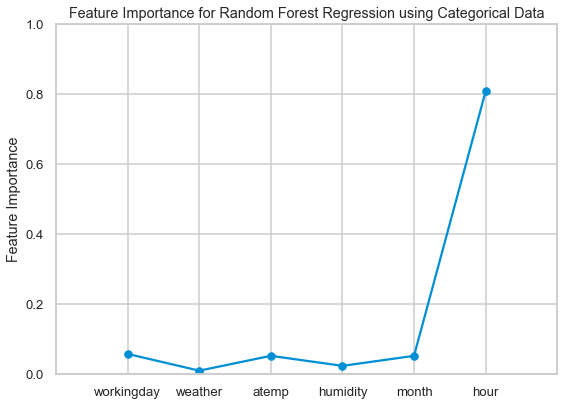

In [998]:
# Plotting the Feature Importance
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfa.feature_importances_, marker='.', markersize=15)
plt.xticks(range(len(rfc.feature_importances_)), X2.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using Categorical Data')
axes.set(xlim=[-1, len(X2.columns)], ylim=[0, 1])

plt.show()

**Observations**
* As expected 'hour' feature holds maximum importance. We saw spikes and dips in count value depending on the hour of the day
* We notice that workingday feature has marginal importance

Let us obtain 2 separate models for working day and non-working day

### b. Using Binary Vector Features obtained from Categorical Features (OneHotEncoder)
Now let model using the other extreme case - 
* All categorical features (weather, month and hour) split into Binary Vector Features, namely weather_1, weather_2, month_1, month_2, ..., month_11, hour_1, hour_2, ..., hour_22, 
* Use two separate models for working day and non-working day to predict the bike count

**Hyperparameter Tuning**  
Procedure 
1. Tune for (n_estimators, max_features) using default values of the remaining parameters
2. Tune for min_samples_leaf using the best n_estimators and max_features
3. Tune for max_depth using the best n_estimators, max_features and min_samples_leaf
4. Tune for min_samples_split using the best n_estimators, max_features, min_samples_leaf and max_depth

In [990]:
# Head of the Traning data
X_w.head(n=2)

atemp  humidity  weather_1  weather_2  month_1  month_2  \
datetime                                                                       
2011-01-03 00:00:00  9.850        44          1          0        1        0   
2011-01-03 01:00:00  8.335        44          1          0        1        0   

                     month_3  month_4  month_5  month_6   ...     hour_13  \
datetime                                                  ...               
2011-01-03 00:00:00        0        0        0        0   ...           0   
2011-01-03 01:00:00        0        0        0        0   ...           0   

                     hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  \
datetime                                                                    
2011-01-03 00:00:00        0        0        0        0        0        0   
2011-01-03 01:00:00        0        0        0        0        0        0   

                     hour_20  hour_21  hour_22  
datetime                                        
2011-01-03 00:00:00        0        0        0  
2011-01-03 01:00:00        0        0        0  

[2 rows x 38 columns]

In [963]:
## Random Forest Regression Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators': [50, 100, 200, 500, 1000, 2000, 5000], 'max_features':['auto', sqrt', 'log2']}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#param_grid_w = {'n_estimators': [2000], 'max_features':['sqrt'], 'min_samples_leaf':[1, 3, 7, 10, 20, 50]}
#param_grid_nw = {'n_estimators': [200], 'max_features':['log2'], 'min_samples_leaf':[1, 3, 7, 10, 20, 50]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#param_grid_w = {'n_estimators': [2000], 'max_features':['sqrt'], 'min_samples_leaf':[1], 'max_depth':[5, 8, 10, 20, 30, 40]}
#param_grid_nw = {'n_estimators': [200], 'max_features':['log2'], 'min_samples_leaf':[1], 'max_depth':[5, 8, 10, 20, 30, 40]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#param_grid_w = {'n_estimators': [2000], 'max_features':['sqrt'], 'min_samples_leaf':[1], 'max_depth':[30], 'min_samples_split':[0.0001, 0.001, 0.002, 0.005, 0.01]}
#param_grid_nw = {'n_estimators': [200], 'max_features':['log2'], 'min_samples_leaf':[1], 'max_depth':[30], 'min_samples_split':[0.0001, 0.001, 0.002, 0.005, 0.01]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#print('Best parameters for Random Forest Regression Model for Working days: {}'.format(rf_w.best_params_))
#print('Best parameters for Random Forest Regression Model for Non Working days: {}'.format(rf_nw.best_params_))


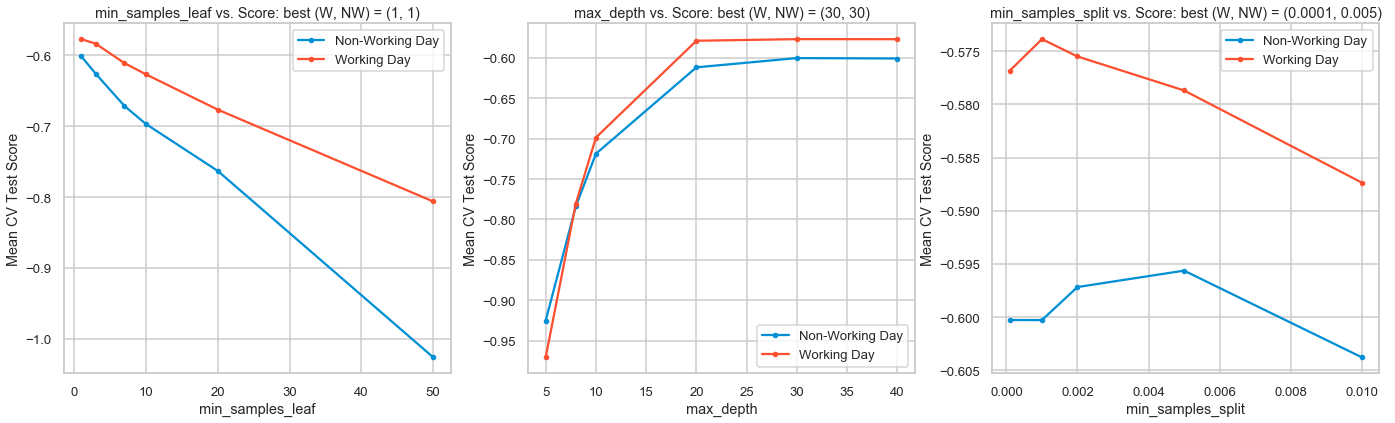

In [964]:
# All the below results are obtained from the above GridSearchCV hyperparamter tuning

fig=plt.figure(figsize=(21, 6))

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score_nw = [-0.6014166 , -0.62586217, -0.6713266 , -0.69684692, -0.76302209, -1.02612827]
min_samples_leaf_cv_score_w = [-0.57692764, -0.58339873, -0.61078536, -0.62668656, -0.67648766, -0.806137]
axes=fig.add_subplot(1, 3, 1)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score: best (W, NW) = (1, 1)')
axes.legend()

max_depth_array = [5, 8, 10, 20, 30, 40]
max_depth_cv_score_nw = [-0.92512009, -0.7837481 , -0.71864241, -0.61170644, -0.60025831, -0.6007901 ]
max_depth_cv_score_w = [-0.97058161, -0.78030942, -0.69859085, -0.57880264, -0.57681758, -0.57689858]
axes=fig.add_subplot(1, 3, 2)
axes.plot(max_depth_array, max_depth_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(max_depth_array, max_depth_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score: best (W, NW) = (30, 30)')
axes.legend()

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score_nw = [-0.60025831, -0.6002647 , -0.59716144, -0.59562094, -0.60375905]
min_samples_split_cv_score_w = [-0.57681758, -0.57386935, -0.57549636, -0.57868933, -0.58734106]
axes=fig.add_subplot(1, 3, 3)
axes.plot(min_samples_split_array, min_samples_split_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_split_array, min_samples_split_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score: best (W, NW) = (0.0001, 0.005)')
axes.legend()

plt.show()

**Model Fit + Predict**

In [965]:
# Random Forest Regression

# Best parameters obtained via GridSearchCV above
best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w = 2000, 'sqrt', 1, 30, 0.0001
best_n_estimators_nw, best_max_features_nw ,best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw = 200, 'log2', 1, 30, 0.005
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_nw, best_max_features_nw, best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw)]

print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

rfb_w = RandomForestRegressor(n_estimators=best_n_estimators_w, max_features=best_max_features_w, min_samples_leaf=best_min_samples_leaf_w, 
                             max_depth=best_max_depth_w, min_samples_split=best_min_samples_split_w, random_state=42)
rfb_nw = RandomForestRegressor(n_estimators=best_n_estimators_nw, max_features=best_max_features_nw, min_samples_leaf=best_min_samples_leaf_nw, 
                             max_depth=best_max_depth_nw, min_samples_split=best_min_samples_split_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(rfb_w, X_w, Xtest_w, y_w, ytest_w, rfb_nw, X_nw, Xtest_nw, y_nw, ytest_nw)

algo_score.loc['Random Forest-OneHotEncoding'] = rmsle_summary+param_summary
algo_score.loc[['Random Forest-OneHotEncoding']]


Best parameters via GridSearchCV for Working Day:     n_estimators: 2000, max_features: sqrt, min_samples_leaf: 1, max_depth: 30, min_samples_split: 0.0001
Best parameters via GridSearchCV for Non Working Day: n_estimators: 200, max_features: log2, min_samples_leaf: 1, max_depth: 30, min_samples_split: 0.005


Train RMSLE (Working Day)  \
Modelling Algo                                            
Random Forest-OneHotEncoding                   0.181896   

                              Train RMSLE (Non Working Day)  \
Modelling Algo                                                
Random Forest-OneHotEncoding                       0.378182   

                              Train RMSLE (Average)  Test RMSLE (Working Day)  \
Modelling Algo                                                                  
Random Forest-OneHotEncoding               0.259781                  0.420388   

                              Test RMSLE (Non Working Day)  \
Modelling Algo                                               
Random Forest-OneHotEncoding                      0.539253   

                              Test RMSLE (Average)  \
Modelling Algo                                       
Random Forest-OneHotEncoding              0.463625   

                                                        Hyperparameters-Working  \
Modelling Algo                                                                    
Random Forest-OneHotEncoding  n_estimators: 2000, max_features: sqrt, min_sa...   

                                                    Hyperparameters-Non Working  
Modelling Algo                                                                   
Random Forest-OneHotEncoding  n_estimators: 200, max_features: log2, min_sam...

**Observations**
* We see a dip in prediction relative to our earlier Random Forest model (which used Categorical Features and single model for working and non-working days). Average Test RMSLE increases from 0.43 to 0.46 
* Also note that the Train RMSLE is reasonably lower than Test RMSLE. This possibly is a result of on over-fit model

**Prediction Plot for Test data in a month (last 5 days of a month)**

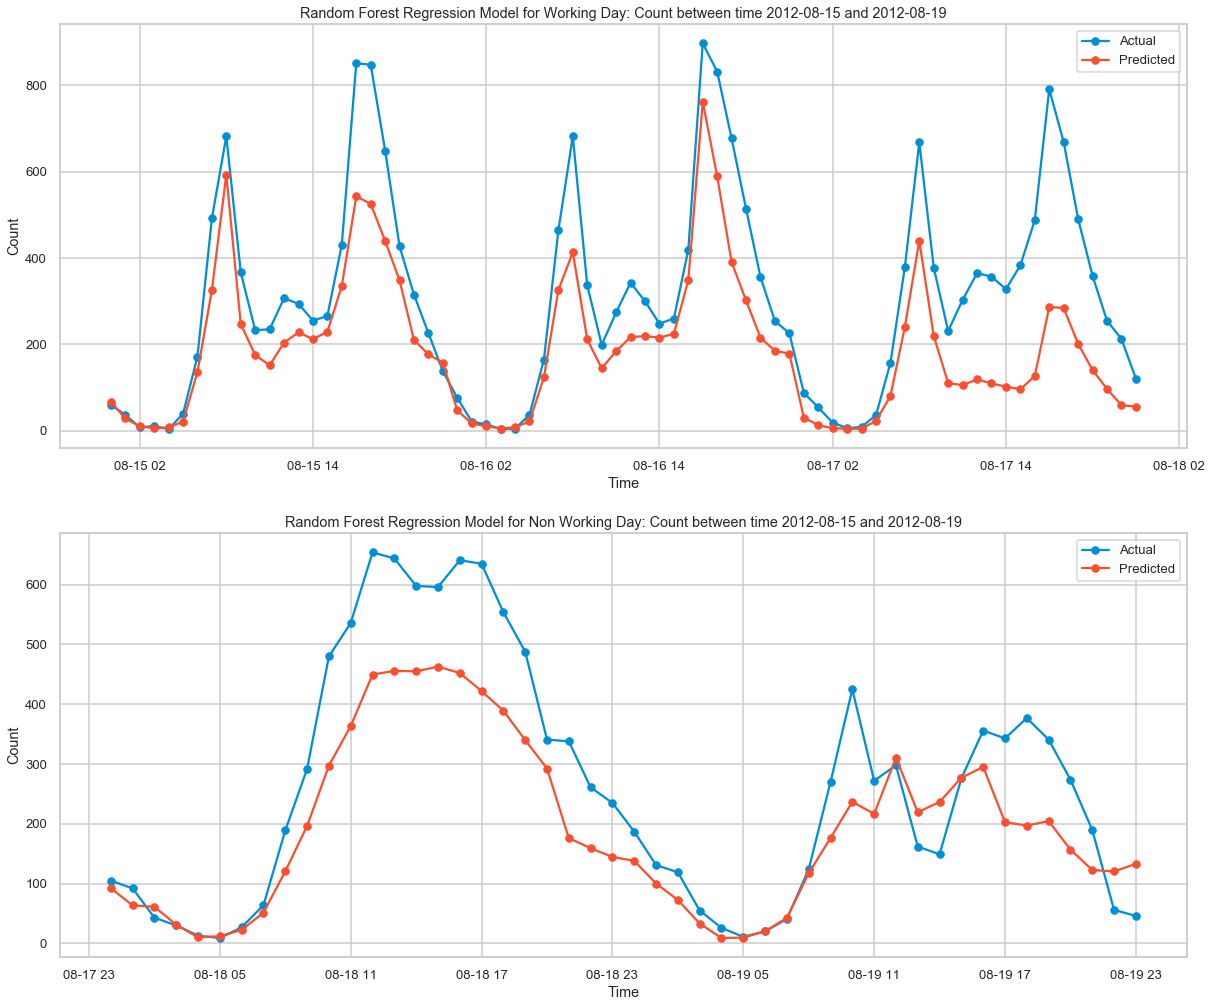

In [966]:
# Random Forest Regression Plot: True vs. Predicted for one month 
t_from, t_to = '2012-08-15', '2012-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Random Forest Regression', t_from, t_to)

**Feature Importance**

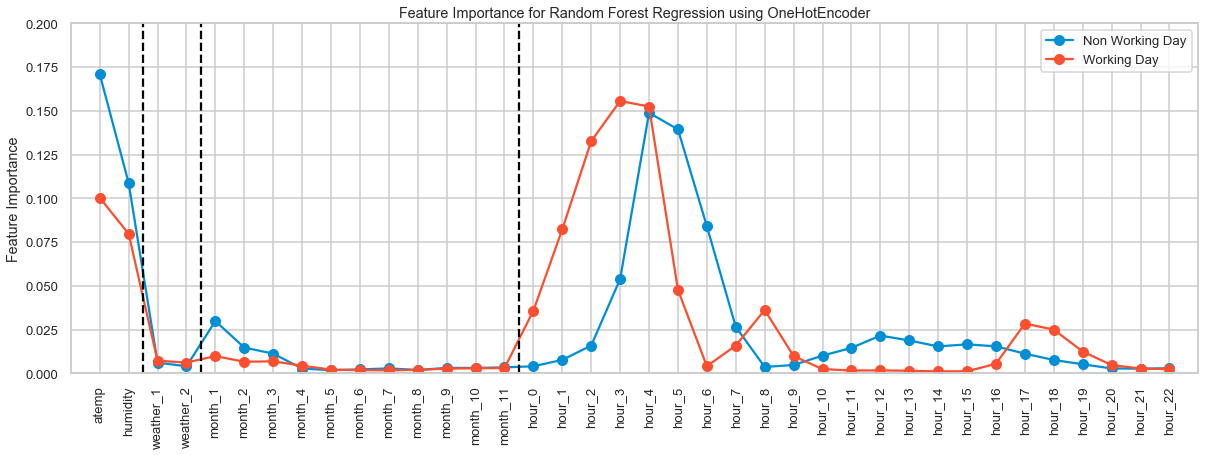

In [967]:
# Plotting the Feature Importance
fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfb_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(rfb_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(rfb_w.feature_importances_)), X_w.columns, rotation=90)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X_w.columns)], ylim=[0, 0.2])
axes.legend()

plt.show()

**Observations**
* Features for which the average count is significantly different from the generic mean count (late night or peak hours), tends to hold higher weightage. For example
    * Non working day hour_x feature set: hour_3 to hour_6 have high importance as the average count at these hours are very low compared to the daily average. Not splitting based on these features correctly would result in higher mse. The peak hours for non-working days are at 1pm and 2pm; correspondingly, we do see relatively higher importance for hour_12 and hour_13
    * Working day hour_x feature set: hour_1 to hour_4 have high importance for similar reasons explained in the previous bullet. hour_8, hour_17, hour_18 too hold reasonably high importance since they are the peak hours and tend to have higher than usual count values 

### c. Using Categorical Features

* Let us try out an intermediate approach. Use 2 separate models for working and non-working days; but use the orginal categorical weather, month and hour data instead of the column vectors obtained using OneHotEncoder


**Hyperparameter Tuning**  
Procedure 
1. Tune for (n_estimators, max_features) using default values of the remaining parameters
2. Tune for min_samples_leaf using the best n_estimators and max_features
3. Tune for max_depth using the best n_estimators, max_features and min_samples_leaf
4. Tune for min_samples_split using the best n_estimators, max_features, min_samples_leaf and max_depth

In [968]:
# Head of the Traning data
X2_w.head(n=3)

weather  atemp  humidity month hour
datetime                                                
2011-01-03 00:00:00        1  9.850        44     1    0
2011-01-03 01:00:00        1  8.335        44     1    1
2011-01-03 04:00:00        1  6.820        47     1    4

In [969]:
## Random Forest Regression Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators': [50, 100, 200, 500, 1000, 2000, 5000], 'max_features':['auto', sqrt', 'log2']}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#param_grid_w = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[1, 3, 7, 10, 20, 50]}
#param_grid_nw = {'n_estimators': [500], 'max_features':['sqrt'], 'min_samples_leaf':[1, 3, 7, 10, 20, 50]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X2_w, logy2_w)
#rf_nw.fit(X2_nw, logy2_nw)

#param_grid_w = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[3], 'max_depth':[5, 8, 10, 20, 30, 40]}
#param_grid_nw = {'n_estimators': [500], 'max_features':['sqrt'], 'min_samples_leaf':[3], 'max_depth':[5, 8, 10, 20, 30, 40]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#param_grid_w = {'n_estimators': [500], 'max_features':['auto'], 'min_samples_leaf':[3], 'max_depth':[20], 'min_samples_split':[0.0001, 0.001, 0.002, 0.005, 0.01]}
#param_grid_nw = {'n_estimators': [500], 'max_features':['sqrt'], 'min_samples_leaf':[3], 'max_depth':[30], 'min_samples_split':[0.0001, 0.001, 0.002, 0.005, 0.01]}
#rf_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_w, cv=5, scoring=rmsle_cv)
#rf_nw = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_nw, cv=5, scoring=rmsle_cv)
#rf_w.fit(X_w, logy_w)
#rf_nw.fit(X_nw, logy_nw)

#print('Best parameters for Random Forest Regression Model for Working days: {}'.format(rf_w.best_params_))
#print('Best parameters for Random Forest Regression Model for Non Working days: {}'.format(rf_nw.best_params_))


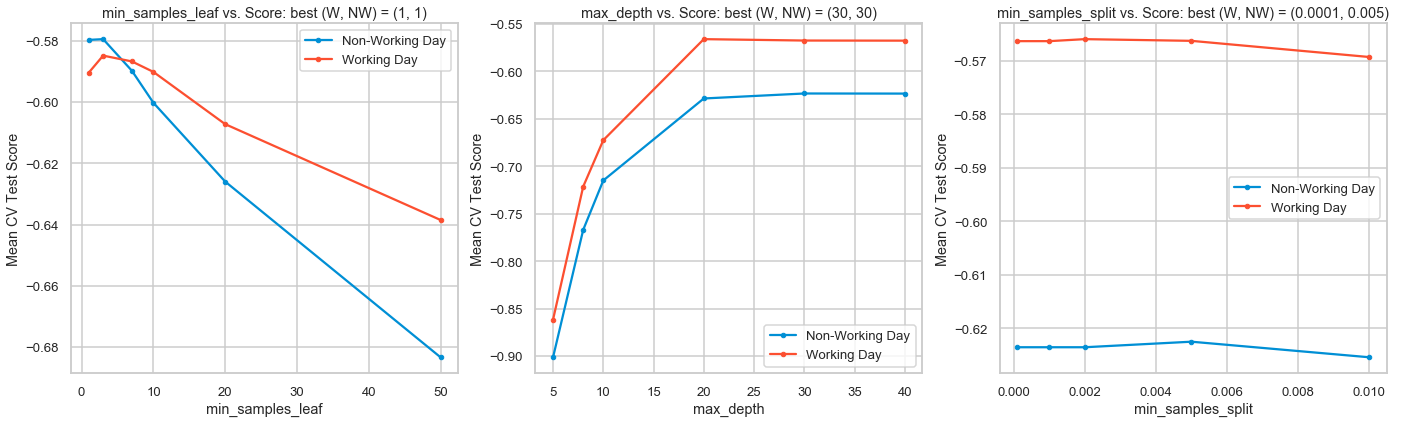

In [970]:
# All the below results are obtained from the above GridSearchCV hyperparamter tuning

fig=plt.figure(figsize=(21, 6))

min_samples_leaf_array = [1, 3, 7, 10, 20, 50]
min_samples_leaf_cv_score_nw = [-0.57970417, -0.57946332, -0.58976635, -0.6002362 , -0.6259668 ,
       -0.68333543]
min_samples_leaf_cv_score_w = [-0.59039957, -0.58484149, -0.58673642, -0.59015947, -0.60721752,
       -0.63850817]
axes=fig.add_subplot(1, 3, 1)
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_leaf_array, min_samples_leaf_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_leaf', ylabel='Mean CV Test Score', title='min_samples_leaf vs. Score: best (W, NW) = (1, 1)')
axes.legend()

max_depth_array = [5, 8, 10, 20, 30, 40]
max_depth_cv_score_nw = [-0.9013261 , -0.76711388, -0.7151308 , -0.6287906 , -0.62354017, -0.62364191]
max_depth_cv_score_w = [-0.86157536, -0.72155214, -0.67269418, -0.56630213, -0.56777392, -0.56789159]
axes=fig.add_subplot(1, 3, 2)
axes.plot(max_depth_array, max_depth_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(max_depth_array, max_depth_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='max_depth', ylabel='Mean CV Test Score', title='max_depth vs. Score: best (W, NW) = (30, 30)')
axes.legend()

min_samples_split_array = [0.0001, 0.001, 0.002, 0.005, 0.01]
min_samples_split_cv_score_nw = [-0.62354017, -0.62354017, -0.62354017, -0.62250308, -0.62541206]
min_samples_split_cv_score_w = [-0.56630213, -0.56630213, -0.56592649, -0.56624378, -0.56926262]
axes=fig.add_subplot(1, 3, 3)
axes.plot(min_samples_split_array, min_samples_split_cv_score_nw, marker='.', label='Non-Working Day')
axes.plot(min_samples_split_array, min_samples_split_cv_score_w, marker='.', label='Working Day')
axes.set(xlabel='min_samples_split', ylabel='Mean CV Test Score', title='min_samples_split vs. Score: best (W, NW) = (0.0001, 0.005)')
axes.legend()

plt.show()

**Model Fit + Predict**

In [971]:
# Random Forest Regression

# Best parameters obtained via GridSearchCV above
best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w = 500, 'auto', 3, 20, 0.002
best_n_estimators_nw, best_max_features_nw ,best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw = 500, 'sqrt', 3, 30, 0.005
param_summary = ['n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_w, best_max_features_w, best_min_samples_leaf_w, best_max_depth_w, best_min_samples_split_w), 
                 'n_estimators: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}, min_samples_split: {}'.format(best_n_estimators_nw, best_max_features_nw, best_min_samples_leaf_nw, best_max_depth_nw, best_min_samples_split_nw)]

print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

rfc_w = RandomForestRegressor(n_estimators=best_n_estimators_w, max_features=best_max_features_w, min_samples_leaf=best_min_samples_leaf_w, 
                             max_depth=best_max_depth_w, min_samples_split=best_min_samples_split_w, random_state=42)
rfc_nw = RandomForestRegressor(n_estimators=best_n_estimators_nw, max_features=best_max_features_nw, min_samples_leaf=best_min_samples_leaf_nw, 
                             max_depth=best_max_depth_nw, min_samples_split=best_min_samples_split_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(rfc_w, X2_w, Xtest2_w, y2_w, ytest2_w, rfc_nw, X2_nw, Xtest2_nw, y2_nw, ytest2_nw)

algo_score.loc['Random Forest-Categorical Features'] = rmsle_summary+param_summary
algo_score.loc[['Random Forest-Categorical Features']]

Best parameters via GridSearchCV for Working Day:     n_estimators: 500, max_features: auto, min_samples_leaf: 3, max_depth: 20, min_samples_split: 0.002
Best parameters via GridSearchCV for Non Working Day: n_estimators: 500, max_features: sqrt, min_samples_leaf: 3, max_depth: 30, min_samples_split: 0.005


Train RMSLE (Working Day)  \
Modelling Algo                                                  
Random Forest-Categorical Features                   0.291352   

                                    Train RMSLE (Non Working Day)  \
Modelling Algo                                                      
Random Forest-Categorical Features                       0.343547   

                                    Train RMSLE (Average)  \
Modelling Algo                                              
Random Forest-Categorical Features               0.308635   

                                    Test RMSLE (Working Day)  \
Modelling Algo                                                 
Random Forest-Categorical Features                  0.396701   

                                    Test RMSLE (Non Working Day)  \
Modelling Algo                                                     
Random Forest-Categorical Features                      0.526269   

                                    Test RMSLE (Average)  \
Modelling Algo                                             
Random Forest-Categorical Features              0.444346   

                                                              Hyperparameters-Working  \
Modelling Algo                                                                          
Random Forest-Categorical Features  n_estimators: 500, max_features: auto, min_sam...   

                                                          Hyperparameters-Non Working  
Modelling Algo                                                                         
Random Forest-Categorical Features  n_estimators: 500, max_features: sqrt, min_sam...

**Observations**
* Average Test RMSLE = 0.44 which is still a bit higher than 4a Random Forest model
* The average training RMSLE = 0.31 indicates that the model might be a bit overfit

**Prediction Plot for Test data in a month (last 5 days of a month)**

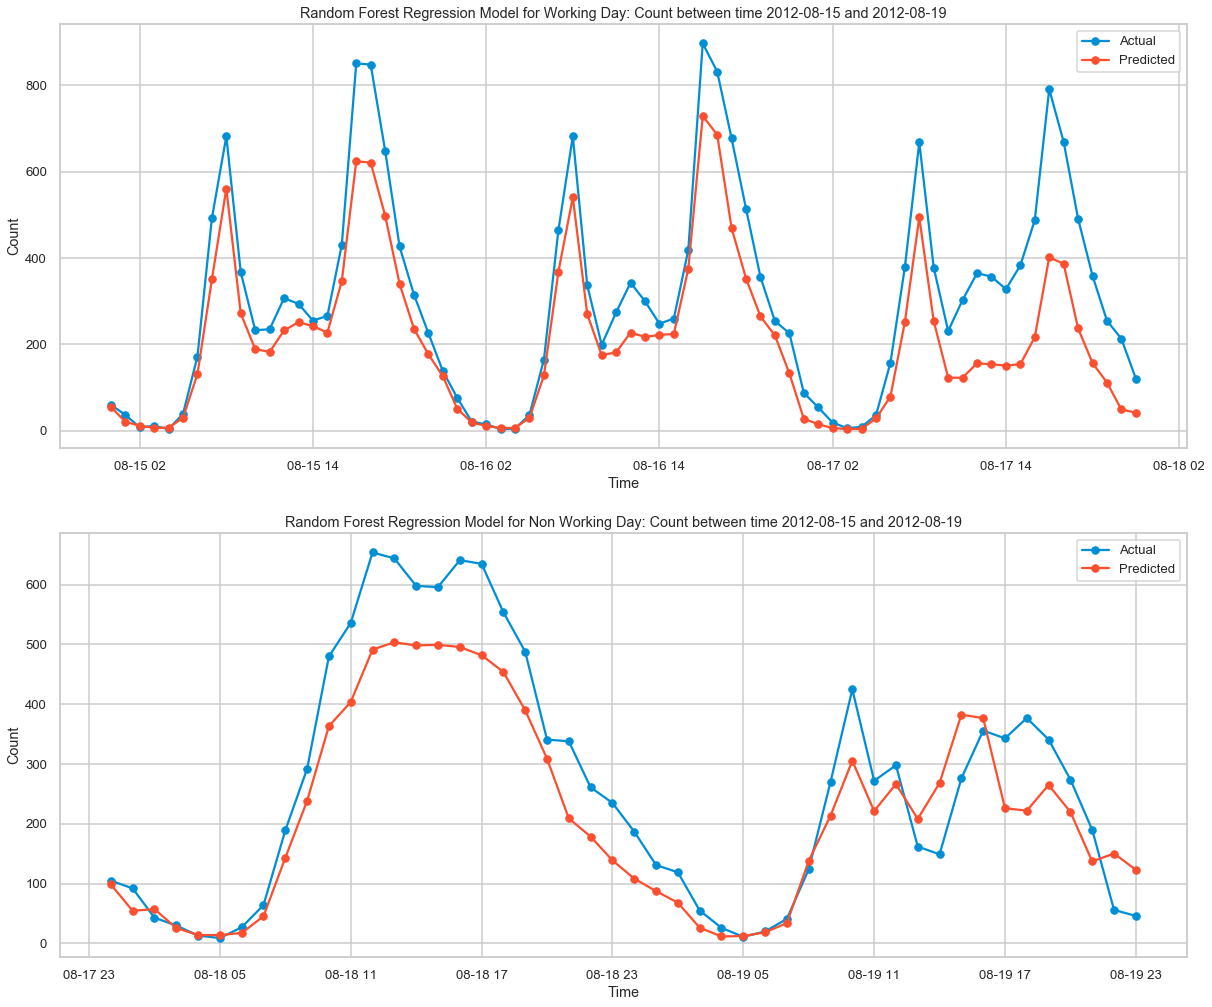

In [972]:
# Random Forest Regression Plot: True vs. Predicted for one month 
t_from, t_to = '2012-08-15', '2012-08-19'
ytest_w_predict, ytest_nw_predict = y_predict_summary[1], y_predict_summary[3]
ytest_w_predict = pd.Series(ytest_w_predict, index = ytest_w.index)
ytest_nw_predict = pd.Series(ytest_nw_predict, index = ytest_nw.index)

plot_true_vs_pred(ytest_w, ytest_nw, ytest_w_predict, ytest_nw_predict, 'Random Forest Regression', t_from, t_to)

**Observations**
* Using hour, weather and month in its raw categorical form seem to improve our Model prediction accuracy

**Feature Importance**

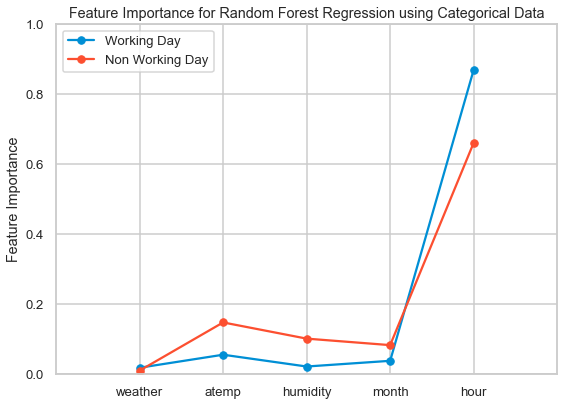

In [999]:
# Plotting the Feature Importance
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(rfc_w.feature_importances_, label='Working Day', marker='.', markersize=15)
axes.plot(rfc_nw.feature_importances_, label='Non Working Day', marker='.', markersize=15)
plt.xticks(range(len(rfc_w.feature_importances_)), X2_w.columns)
axes.set(ylabel='Feature Importance', title='Feature Importance for Random Forest Regression using Categorical Data')
axes.set(xlim=[-1, len(X2_w.columns)], ylim=[0, 1])
axes.legend()

plt.show()

**Observations**
* The feature importance is similar to the ones in our 4a. model

**Decision Tree Visualization**  
Random Forest uses an ensemble of 500 decision trees in our earlier model. Let us visualize one of them and see if it makes sense. The entire tree would have several leaf nodes and would be difficult to analyze. Instead, let us limit the max_depth to 3 and plot the decision tree. 

RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = 0.641


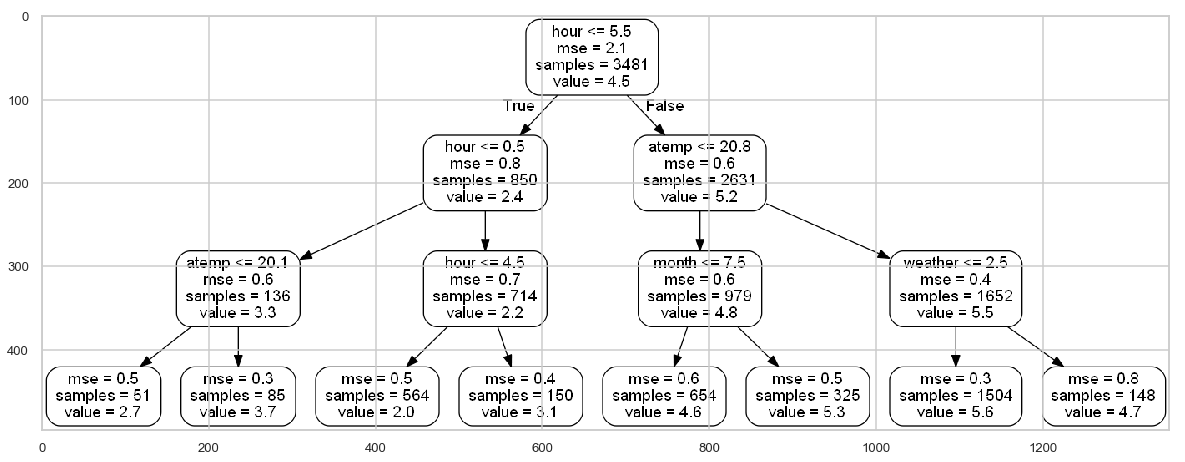

In [974]:
# Visualizing a graph limiting the tree to 3 levels to gain some understanding 
rf_w_small = RandomForestRegressor(n_estimators=10, max_features = 'auto', max_depth=3, random_state=42)
rf_w_small.fit(X2_w, logy2_w)
logy2_w_predict_small = rf_w_small.predict(X2_w)
rmsle2_w_small = rmsle(y2_w, np.expm1(logy2_w_predict_small))
print('RMSLE score for Random Forest Regressor using a small tree (max_depth = 3) for simple visualization = {0:.3f}'.format(rmsle2_w_small))

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

# Pull out one tree from the forest
tree = rf_w_small.estimators_[0]
# Export the image to a dot file
dot_data = export_graphviz(tree, out_file = 'tree.dot', feature_names = X2_w.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

img=mpimg.imread('tree.png')
plt.figure(figsize=(18, 12))
imgplot = plt.imshow(img)
plt.show()

**Observations**
* Since we limited the above tree to max_depth = 3, we see only 8 leaf nodes. Based on 3 condition checks (at each depth), we arrive at one of these 8 nodes. 
* The value indicated at the leaf node corresponds to the predicted value (which is log(1+count))
* The first split is made based on hour feature indicating that it is very important (since that first split at 5.5 hours  minimizes the mse) which makes sense
* Note that the number of samples = 3481 at the root node (instead of 5507 which is the total number of observations in X_w). THis is because Random Forest Regression works on a bootstrap sample, and the above bootstrap sample contained just 4868 unique observation

### 5. Ensemble Method - Gradient Boost

### a. Using Binary Vector Features obtained from Categorical Features (OneHotEncoder)

**Hyperparameter Tuning**  
Procedure adopted to tune the parameters
1. Pick a large n_estimator = 3000
2. Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search.
3. Increase n_estimators even more (5000) and tune learning_rate again holding the other parameters fixed.

In [975]:
## Gradient Boost Regression Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators':[3000], 'learning_rate':[0.01, 0.02, 0.05, 0.1], 'max_depth':[3, 4, 6], 'max_features':[1, 0.3, 0.1], 'min_samples_leaf':[1, 3, 5]}
#param_grid = {'n_estimators':[3000], 'learning_rate':[0.01], 'max_depth':[6], 'max_features':[1], 'min_samples_leaf':[1, 5, 9, 13, 21, 25]}
#param_grid = {'n_estimators':[3000, 5000], 'learning_rate':[0.002, 0.005, 0.01], 'max_depth':[6], 'max_features':[1], 'min_samples_leaf':[5]}
#gb_w = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#gb_w.fit(X_w, logy_w)
#print('Best parameters for Working Day Gradient Boosting Regression Model: {}'.format(gb_w.best_params_))

#param_grid = {'n_estimators':[3000, 5000], 'learning_rate':[0.002, 0.005, 0.01], 'max_depth':[6], 'max_features':[1], 'min_samples_leaf':[5]}
#gb_nw = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#gb_nw.fit(X_nw, logy_nw)
#print('Best parameters for Non Working Day Gradient Boosting Regression Model: {}'.format(gb_nw.best_params_))


**Model Fit + Predict**

In [976]:
# Gradient Boosting Regression

# Best parameters obtained via GridSearchCV above
best_max_depth, best_max_features, best_min_samples_leaf = 6, 1.0, 5
best_n_estimators_w, best_learning_rate_w = 3000, 0.01
best_n_estimators_nw, best_learning_rate_nw = 3000, 0.005
param_summary = ['n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_w, best_learning_rate_w, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_nw, best_learning_rate_nw, best_max_features, best_min_samples_leaf, best_max_depth)]
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

gb_w = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, 
                                 max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)
gb_nw = GradientBoostingRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, 
                                  max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)

rmsle_summary, y_predict_summary = model_fit(gb_w, X_w, Xtest_w, y_w, ytest_w, gb_nw, X_nw, Xtest_nw, y_nw, ytest_nw)

algo_score.loc['Gradient Boosting-OneHotEncoding'] = rmsle_summary+param_summary
algo_score.loc[['Gradient Boosting-OneHotEncoding']]

Best parameters via GridSearchCV for Working Day:     n_estimators: 3000, learning_rate: 0.01, max_features: 1.0, min_samples_leaf: 5, max_depth: 6
Best parameters via GridSearchCV for Non Working Day: n_estimators: 3000, learning_rate: 0.005, max_features: 1.0, min_samples_leaf: 5, max_depth: 6


Train RMSLE (Working Day)  \
Modelling Algo                                                
Gradient Boosting-OneHotEncoding                   0.274146   

                                  Train RMSLE (Non Working Day)  \
Modelling Algo                                                    
Gradient Boosting-OneHotEncoding                       0.293993   

                                  Train RMSLE (Average)  \
Modelling Algo                                            
Gradient Boosting-OneHotEncoding               0.280507   

                                  Test RMSLE (Working Day)  \
Modelling Algo                                               
Gradient Boosting-OneHotEncoding                  0.418195   

                                  Test RMSLE (Non Working Day)  \
Modelling Algo                                                   
Gradient Boosting-OneHotEncoding                       0.54939   

                                  Test RMSLE (Average)  \
Modelling Algo                                           
Gradient Boosting-OneHotEncoding              0.466287   

                                                            Hyperparameters-Working  \
Modelling Algo                                                                        
Gradient Boosting-OneHotEncoding  n_estimators: 3000, learning_rate: 0.01, max_f...   

                                                        Hyperparameters-Non Working  
Modelling Algo                                                                       
Gradient Boosting-OneHotEncoding  n_estimators: 3000, learning_rate: 0.005, max_...

**Observations**
* Performs a bit worse compared to the best Random Forest model (4a)
* This again possibly is an overfit model

**Feature Importance Plot**

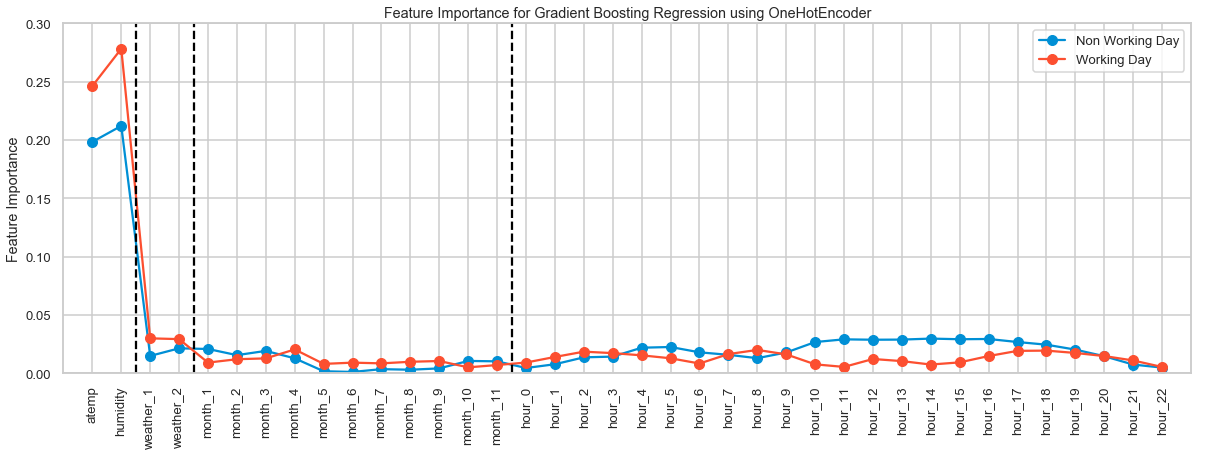

In [977]:
# Plotting the Feature Importance
fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(gb_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(gb_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(gb_w.feature_importances_)), X_w.columns, rotation=90)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
axes.set(ylabel='Feature Importance', title='Feature Importance for Gradient Boosting Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X_w.columns)], ylim=[0, 0.3])
axes.legend()

plt.show()

**Observations**
* Higher RMSLE observed compared to Random Forest Regression
* Unlike Random Forest Regression, there isn't a lot of significant difference in the various hours_x features 

**Decision Tree Visualization**
All the individual Decision Tree Estimator used for Gradient Boosting has a depth of 6. Let us use a smaller max_depth (3) to gain some insight 

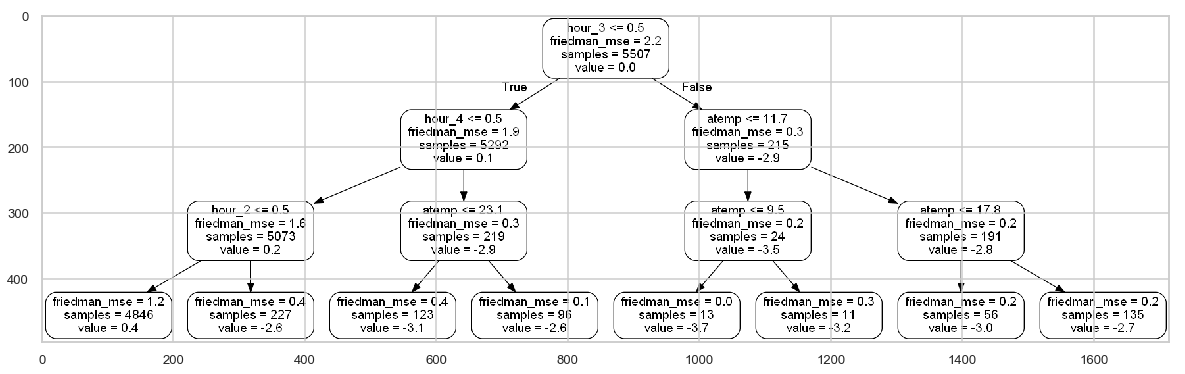

In [978]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

gb_w_small = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, max_depth=3, random_state=42)
gb_w_small.fit(X_w, logy_w)

# Pull out one tree from the forest
tree = gb_w_small.estimators_[0][0]
# Export the image to a dot file
dot_data = export_graphviz(tree, out_file = 'tree2.dot', feature_names = X_w.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree2.dot')
# Write graph to a png file
graph.write_png('tree2.png')

img=mpimg.imread('tree2.png')
plt.figure(figsize=(18, 12))
imgplot = plt.imshow(img)
plt.show()

**Observations**
* Each estimator corresponds to 3-level Decision Tree which is applied on the residue obtained till that point
* The very first estimator is the mean of the observed value (mean of the count)
* The above graph corresponds to the first Decision Tree estimator applied on the residue = X_w - mean
* Note that the graph is almost similar to the one obtained before via Random Forest Regression with max_depth = 3. The difference is due to the randomness in the bootstrap sample for Random Forest Method
* Also note that the value in each leaf node corresponds to the estimator on the residue = X_w - mean and hence is different from the ones seen for the Random Forest graph plot


### b. Using Categorical Features
* As with Random Forest approach, let us check if OneHotEncoder provided any benefit

**Hyperparameter Tuning**

In [979]:
## Gradient Boost Regression Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators':[3000], 'learning_rate':[0.005, 0.01, 0.02, 0.05, 0.1], 'max_depth':[4, 6], 'max_features':[1, 0.3, 0.1], 'min_samples_leaf':[13, 17, 21, 25]}
#param_grid = {'n_estimators':[3000, 5000], 'learning_rate':[0.002, 0.005, 0.01], 'max_depth':[4], 'max_features':[1], 'min_samples_leaf':[21]}
#gb2_w = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#gb2_w.fit(X2_w, logy2_w)
#print('Best parameters for Working Day Gradient Boosting Regression Model: {}'.format(gb2_w.best_params_))

#gb2_nw = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#gb2_nw.fit(X2_nw, logy2_nw)
#print('Best parameters for Non Working Day Gradient Boosting Regression Model: {}'.format(gb2_nw.best_params_))


In [980]:
# Gradient Boosting Regression

# Best parameters obtained via GridSearchCV above

best_max_depth, best_max_features, best_min_samples_leaf = 4, 1.0, 21
best_n_estimators_w, best_learning_rate_w = 3000, 0.01
best_n_estimators_nw, best_learning_rate_nw = 3000, 0.005
param_summary = ['n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_w, best_learning_rate_w, best_max_features, best_min_samples_leaf, best_max_depth), 
                 'n_estimators: {}, learning_rate: {}, max_features: {}, min_samples_leaf: {}, max_depth: {}'.format(best_n_estimators_nw, best_learning_rate_nw, best_max_features, best_min_samples_leaf, best_max_depth)]
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

gb2_w = GradientBoostingRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, 
                                 max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)
gb2_nw = GradientBoostingRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, 
                                  max_depth=best_max_depth, max_features=best_max_features, min_samples_leaf=best_min_samples_leaf, random_state=42)

rmsle_summary, y_predict_summary = model_fit(gb2_w, X2_w, Xtest2_w, y2_w, ytest2_w, gb2_nw, X2_nw, Xtest2_nw, y2_nw, ytest2_nw)

algo_score.loc['Gradient Boosting-Categorical Features'] = rmsle_summary+param_summary
algo_score.loc[['Gradient Boosting-Categorical Features']]

Best parameters via GridSearchCV for Working Day:     n_estimators: 3000, learning_rate: 0.01, max_features: 1.0, min_samples_leaf: 21, max_depth: 4
Best parameters via GridSearchCV for Non Working Day: n_estimators: 3000, learning_rate: 0.005, max_features: 1.0, min_samples_leaf: 21, max_depth: 4


Train RMSLE (Working Day)  \
Modelling Algo                                                      
Gradient Boosting-Categorical Features                    0.31179   

                                        Train RMSLE (Non Working Day)  \
Modelling Algo                                                          
Gradient Boosting-Categorical Features                       0.329822   

                                        Train RMSLE (Average)  \
Modelling Algo                                                  
Gradient Boosting-Categorical Features               0.317543   

                                        Test RMSLE (Working Day)  \
Modelling Algo                                                     
Gradient Boosting-Categorical Features                  0.397755   

                                        Test RMSLE (Non Working Day)  \
Modelling Algo                                                         
Gradient Boosting-Categorical Features                      0.504389   

                                        Test RMSLE (Average)  \
Modelling Algo                                                 
Gradient Boosting-Categorical Features              0.436399   

                                                                  Hyperparameters-Working  \
Modelling Algo                                                                              
Gradient Boosting-Categorical Features  n_estimators: 3000, learning_rate: 0.01, max_f...   

                                                              Hyperparameters-Non Working  
Modelling Algo                                                                             
Gradient Boosting-Categorical Features  n_estimators: 3000, learning_rate: 0.005, max_...

**Observations**
* Performs on par with Random Forest
* Overfit? 

### 6. Ensemble Method - Adaboost

**Hyperparameter Tuning**  
Procedure adopted to tune the parameters
1. Pick a large n_estimator = 3000 and tune learning_rate for working day model with it
3. Increase n_estimators even more (5000) and tune learning_rate again for both working day and non-working day

In [981]:
## AdaBoost Regression Grid Search to obtain the best parameters. 
## Commented it out since it takes a lot of time to run. Using the best parameters obtained via the below search

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_estimators':[3000], 'learning_rate':[0.0005, 0.001, 0.002, 0.005, 0.01]}
#param_grid = {'n_estimators':[5000, 3000], 'learning_rate':[0.0005, 0.001, 0.002]}
#ab_w = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#ab_w.fit(X_w, logy_w)
#print('Best parameters for Working Day AdaBoost Regression Model: {}'.format(ab_w.best_params_))

#ab_nw = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid, cv=5, scoring=rmsle_cv)
#ab_nw.fit(X_nw, logy_nw)
#print('Best parameters for Non Working Day AdaBoost Regression Model: {}'.format(ab_nw.best_params_))


**Model Building**

In [982]:
# AdaBoost Regression

# Best parameters obtained via GridSearchCV above

best_n_estimators_w, best_learning_rate_w = 5000, 0.001
best_n_estimators_nw, best_learning_rate_nw = 5000, 0.001
param_summary = ['n_estimators: {}, learning_rate: {}'.format(best_n_estimators_w, best_learning_rate_w), 
                 'n_estimators: {}, learning_rate: {}'.format(best_n_estimators_nw, best_learning_rate_nw)]
print('Best parameters via GridSearchCV for Working Day:     '+param_summary[0])
print('Best parameters via GridSearchCV for Non Working Day: '+param_summary[1])

ab_w = AdaBoostRegressor(n_estimators = best_n_estimators_w, learning_rate = best_learning_rate_w, random_state=42)
ab_nw = AdaBoostRegressor(n_estimators = best_n_estimators_nw, learning_rate = best_learning_rate_nw, random_state=42)

rmsle_summary, y_predict_summary = model_fit(ab_w, X_w, Xtest_w, y_w, ytest_w, ab_nw, X_nw, Xtest_nw, y_nw, ytest_nw)

algo_score.loc['AdaBoost-OneHotEncoding'] = rmsle_summary+param_summary
algo_score.loc[['AdaBoost-OneHotEncoding']]

Best parameters via GridSearchCV for Working Day:     n_estimators: 5000, learning_rate: 0.001
Best parameters via GridSearchCV for Non Working Day: n_estimators: 5000, learning_rate: 0.001


Train RMSLE (Working Day)  \
Modelling Algo                                       
AdaBoost-OneHotEncoding                   0.948557   

                         Train RMSLE (Non Working Day)  Train RMSLE (Average)  \
Modelling Algo                                                                  
AdaBoost-OneHotEncoding                       0.834654               0.914442   

                         Test RMSLE (Working Day)  \
Modelling Algo                                      
AdaBoost-OneHotEncoding                  0.930005   

                         Test RMSLE (Non Working Day)  Test RMSLE (Average)  \
Modelling Algo                                                                
AdaBoost-OneHotEncoding                      0.876259              0.912348   

                                          Hyperparameters-Working  \
Modelling Algo                                                      
AdaBoost-OneHotEncoding  n_estimators: 5000, learning_rate: 0.001   

                                      Hyperparameters-Non Working  
Modelling Algo                                                     
AdaBoost-OneHotEncoding  n_estimators: 5000, learning_rate: 0.001

**Observations**
* AdaBoost model has higher RMSLE and doesnt perform as well as the other 2 Ensemble methods (RF and GB)

**Feature Importance Plot**

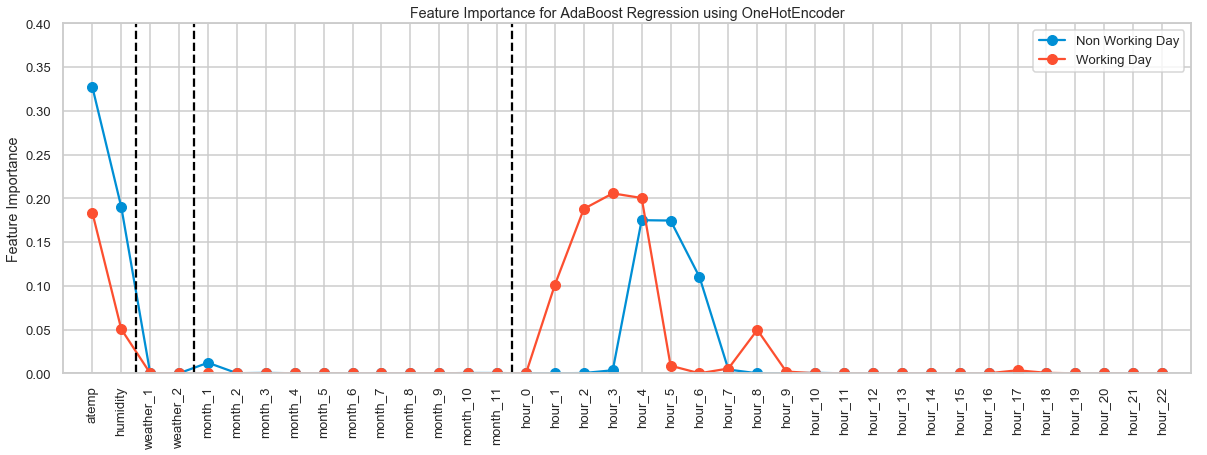

In [983]:
# Plotting the Feature Importance
fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(ab_nw.feature_importances_, label='Non Working Day', marker='.', markersize=20)
axes.plot(ab_w.feature_importances_, label='Working Day', marker='.', markersize=20)
plt.xticks(range(len(ab_w.feature_importances_)), X_w.columns, rotation=90)
axes.axvline(2-0.5, c='k', ls='--')
axes.axvline(4-0.5,  c='k', ls='--')
axes.axvline(15-0.5,  c='k', ls='--')
axes.set(ylabel='Feature Importance', title='Feature Importance for AdaBoost Regression using OneHotEncoder')
axes.set(xlim=[-1, len(X_w.columns)], ylim=[0, 0.4])
axes.legend()

plt.show()

**Observations**
* Like Random Forest Regressor, AdaBoostRegressor prioritize the features for which the average count is significantly different from the mean count (hour_4 to hour_6 for Non working day and hour_1 to hour_4 for working day)

**Plots of Estimator Error and Estimator Weights**

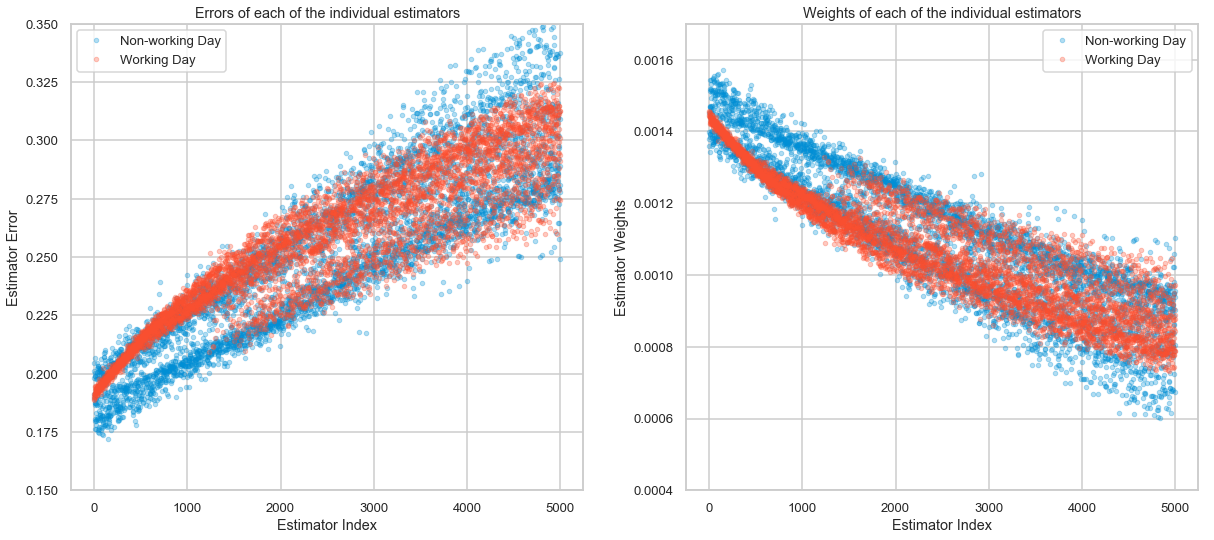

In [984]:
fig = plt.figure(figsize=(18, 8))

# Estimator Error Plot
axes = fig.add_subplot(1, 2, 1)
axes.plot(ab_nw.estimator_errors_, linestyle='None', marker='.', alpha=0.3, label = 'Non-working Day')
axes.plot(ab_w.estimator_errors_, linestyle='None', marker='.', alpha=0.3, label='Working Day')
axes.set(xlabel='Estimator Index', ylabel='Estimator Error', title='Errors of each of the individual estimators')
axes.set(ylim=[0.15, 0.35])
axes.legend()

# Estimator Weight Plot
axes = fig.add_subplot(1, 2, 2)
axes.plot(ab_nw.estimator_weights_, linestyle='None', marker='.', alpha=0.3, label = 'Non-working Day')
axes.plot(ab_w.estimator_weights_, linestyle='None', marker='.', alpha=0.3, label = 'Working Day')
axes.set(xlabel='Estimator Index', ylabel='Estimator Weights', title='Weights of each of the individual estimators')
axes.set(ylim=[0.0004, 0.0017])
axes.legend()
plt.show()

**Observations**
* From the above plot, it doesnt look like AdaBoost is a good model for this problem. Every subsequent estimator seems to result in an increase in the error (and as a result, we give it a lower weight for our final combined estimator model)

### RMSLE Summary

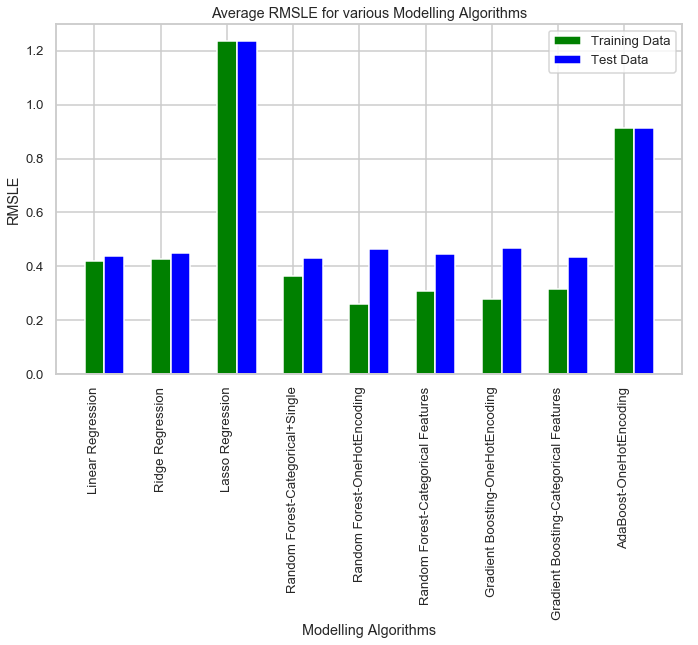

In [985]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Train RMSLE (Average)', x=idx, color='g', width=bar_width, label='Training Data')
plt.bar(data=algo_score, height='Test RMSLE (Average)', x=idx+bar_width, color='b', width=bar_width, label='Test Data')
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('RMSLE')
plt.title('Average RMSLE for various Modelling Algorithms')
plt.legend()
plt.show()

In [1000]:
# Detailed split of RMSLE
algo_score

Train RMSLE (Working Day)  \
Modelling Algo                                                      
Linear Regression                                        0.415613   
Ridge Regression                                         0.420662   
Lasso Regression                                         1.311302   
Random Forest-Categorical+Single                         0.354905   
Random Forest-OneHotEncoding                             0.181896   
Random Forest-Categorical Features                       0.291352   
Gradient Boosting-OneHotEncoding                         0.274146   
Gradient Boosting-Categorical Features                   0.311790   
AdaBoost-OneHotEncoding                                  0.948557   

                                        Train RMSLE (Non Working Day)  \
Modelling Algo                                                          
Linear Regression                                            0.430999   
Ridge Regression                                             0.446370   
Lasso Regression                                             1.057510   
Random Forest-Categorical+Single                             0.382949   
Random Forest-OneHotEncoding                                 0.378182   
Random Forest-Categorical Features                           0.343547   
Gradient Boosting-OneHotEncoding                             0.293993   
Gradient Boosting-Categorical Features                       0.329822   
AdaBoost-OneHotEncoding                                      0.834654   

                                        Train RMSLE (Average)  \
Modelling Algo                                                  
Linear Regression                                    0.420488   
Ridge Regression                                     0.428872   
Lasso Regression                                     1.237495   
Random Forest-Categorical+Single                     0.363913   
Random Forest-OneHotEncoding                         0.259781   
Random Forest-Categorical Features                   0.308635   
Gradient Boosting-OneHotEncoding                     0.280507   
Gradient Boosting-Categorical Features               0.317543   
AdaBoost-OneHotEncoding                              0.914442   

                                        Test RMSLE (Working Day)  \
Modelling Algo                                                     
Linear Regression                                       0.405675   
Ridge Regression                                        0.410693   
Lasso Regression                                        1.291060   
Random Forest-Categorical+Single                        0.399774   
Random Forest-OneHotEncoding                            0.420388   
Random Forest-Categorical Features                      0.396701   
Gradient Boosting-OneHotEncoding                        0.418195   
Gradient Boosting-Categorical Features                  0.397755   
AdaBoost-OneHotEncoding                                 0.930005   

                                        Test RMSLE (Non Working Day)  \
Modelling Algo                                                         
Linear Regression                                           0.492574   
Ridge Regression                                            0.516091   
Lasso Regression                                            1.118380   
Random Forest-Categorical+Single                            0.490854   
Random Forest-OneHotEncoding                                0.539253   
Random Forest-Categorical Features                          0.526269   
Gradient Boosting-OneHotEncoding                            0.549390   
Gradient Boosting-Categorical Features                      0.504389   
AdaBoost-OneHotEncoding                                     0.876259   

                                        Test RMSLE (Average)  \
Modelling Algo                                                 
Linear Regression                                   0.436724   
Ridge Regression          

Based on the above result, let us use Single Model Random Forest Regressor Model (with categorical feature) based on the below couple of reasons
* Lowest Average Test RMSLE
* Least Overfit (Train Average RMSLE is closer to Test Average RMSLE)
* Easier to train due to lesser number of features

## Submission

Now that we have picked which model to go with, let us train our model with the entire dataset provided. 

In [1008]:
Xtrain = mydata_without_outliers.drop('count', axis=1)
ytrain = mydata_without_outliers['count']
logytrain = np.log1p(ytrain)

# Best parameters obtained via GridSearchCV above
best_n_estimators, best_max_features = 500, 'auto'
best_min_samples_leaf, best_max_depth = 7, 10

rf_main = RandomForestRegressor(n_estimators = best_n_estimators, max_features = best_max_features, 
                                min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, random_state=42)
rf_main.fit(Xtrain, logytrain)
logytest_predict = rf_main.predict(testdata)
ytest_predict = np.expm1(logytest_predict)

submission = pd.DataFrame({'datetime':testdata.index, 'count':ytest_predict})
submission.to_csv('bikeSharing.csv', index=False)

# This will yield a Test Score = 0.49!

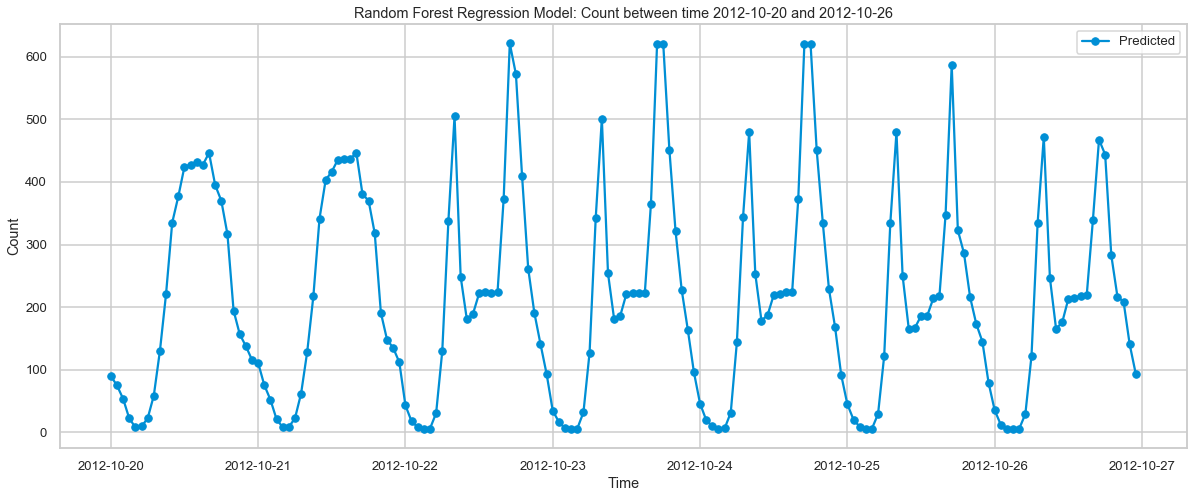

In [1016]:
algo = 'Random Forest Regression'
t_from, t_to = '2012-10-20', '2012-10-26'
ytest_predict = pd.Series(ytest_predict, index = testdata.index)
fig = plt.figure(figsize=(18, 16))
# Working day plot
axes = fig.add_subplot(2, 1, 1)
axes.plot(ytest_predict[t_from:t_to], label='Predicted', marker='.', markersize=15)
axes.set(xlabel='Time', ylabel='Count', title='{0} Model: Count between time {1} and {2}'.format(algo, t_from, t_to))
axes.legend()

plt.show()